In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

In [2]:
input_window = 100
output_window = 5
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = ("cpu")

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [4]:
class TransAm(nn.Module):
    def __init__(self,feature_size=2,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [5]:
import pandas as pd
from datetime import date
# data_ = pd.read_excel('../data/LD_20142.xlsx', 'Sheet1', parse_dates=["date"])
data_ = pd.read_csv('dataset/test.CSV')
data_ = data_.fillna(0)

In [6]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    np.zeros((output_window, 3))
    for i in range(L - tw):
        train_seq = np.append(input_data[i:i + tw, :][:-output_window, :], np.zeros((output_window, 2)), axis=0)
        train_label = input_data[i:i + tw, :]
        # print(train_seq.shape,train_label.shape)
        # train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)


def get_data():
    time = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))

    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    data = data_.loc[:, "concentration":  "amount"]
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    # print(amplitude.shape)
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # print(train_data.shape,test_data.shape)
    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    # print('c',train_data.shape)

    train_sequence = create_inout_sequences(train_data, input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window]  # todo: fix hack?

    # test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]  # todo: fix hack?

    return train_sequence.to(device), test_data.to(device), scaler


def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i + seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1)).squeeze()  # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1)).squeeze()
    return input, target



In [7]:
train_data, val_data,scaler = get_data()
print(train_data.size())
# print(train_data.size(), val_data.size())
tr,te = get_batch(train_data, 0,batch_size)
print(tr.shape,te.shape)

D:\miniconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


torch.Size([2695, 2, 100, 2])
torch.Size([100, 32, 2]) torch.Size([100, 32, 2])


In [8]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [9]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)   

            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data) 
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [10]:
def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)            
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(2):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot(truth[:700],color="black")

        pyplot.plot([k + 510                 for k in range(190)],test_result[510:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(510, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Y")
        pyplot.show()
        pyplot.close()
    return total_loss / i

D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    16/   84 batches | lr 0.005000 | 964.62 ms | loss 0.38196 | ppl     1.47
| epoch   1 |    32/   84 batches | lr 0.005000 | 901.81 ms | loss 0.26918 | ppl     1.31
| epoch   1 |    48/   84 batches | lr 0.005000 | 921.69 ms | loss 0.04789 | ppl     1.05
| epoch   1 |    64/   84 batches | lr 0.005000 | 971.02 ms | loss 0.01309 | ppl     1.01
| epoch   1 |    80/   84 batches | lr 0.005000 | 915.57 ms | loss 0.00935 | ppl     1.01
torch.Size([2096, 2]) torch.Size([2096, 2])


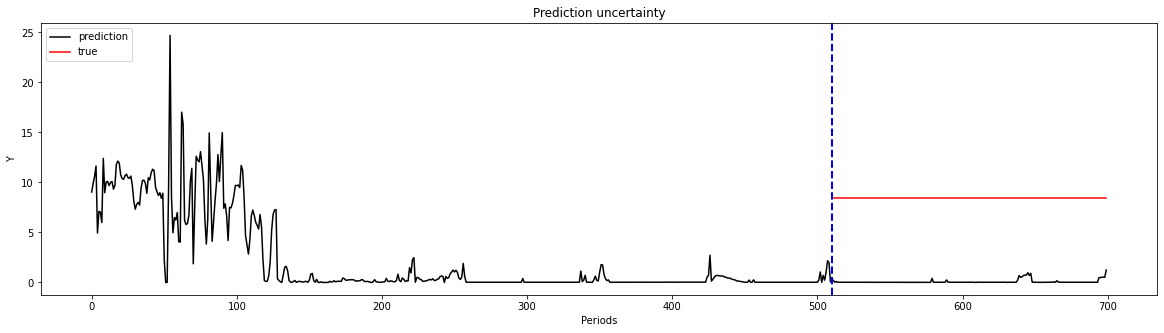

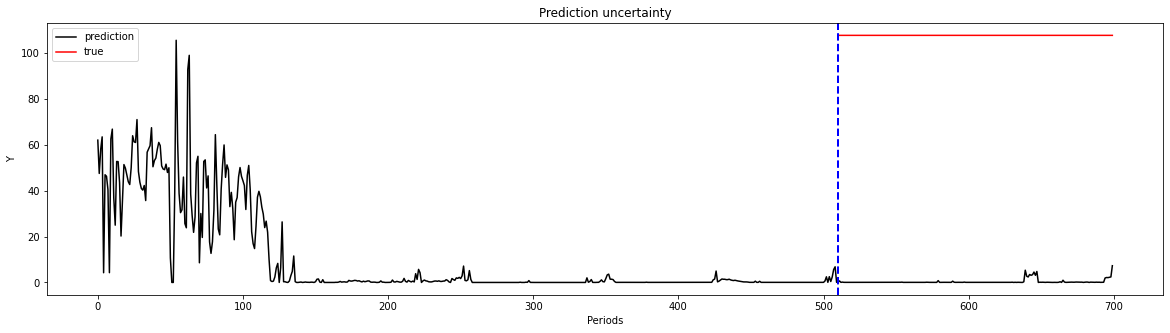

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 89.46s | valid loss 0.03397 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   2 |    16/   84 batches | lr 0.004802 | 963.99 ms | loss 0.07995 | ppl     1.08
| epoch   2 |    32/   84 batches | lr 0.004802 | 905.10 ms | loss 0.09357 | ppl     1.10
| epoch   2 |    48/   84 batches | lr 0.004802 | 927.87 ms | loss 0.02396 | ppl     1.02
| epoch   2 |    64/   84 batches | lr 0.004802 | 979.48 ms | loss 0.00673 | ppl     1.01
| epoch   2 |    80/   84 batches | lr 0.004802 | 897.36 ms | loss 0.00132 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


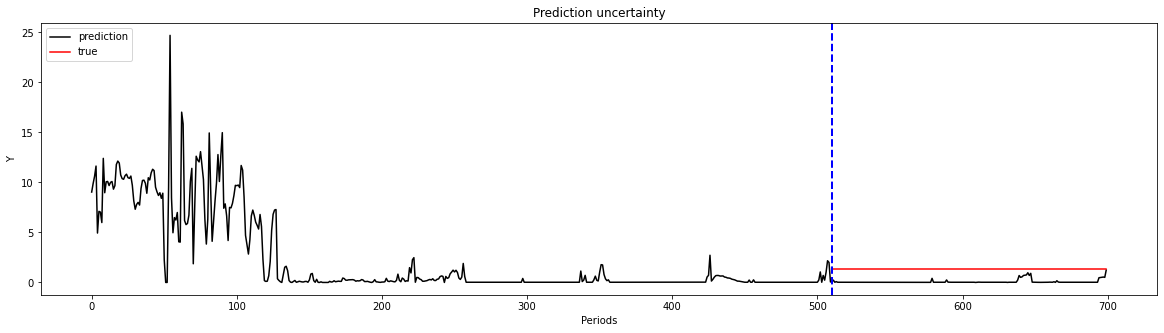

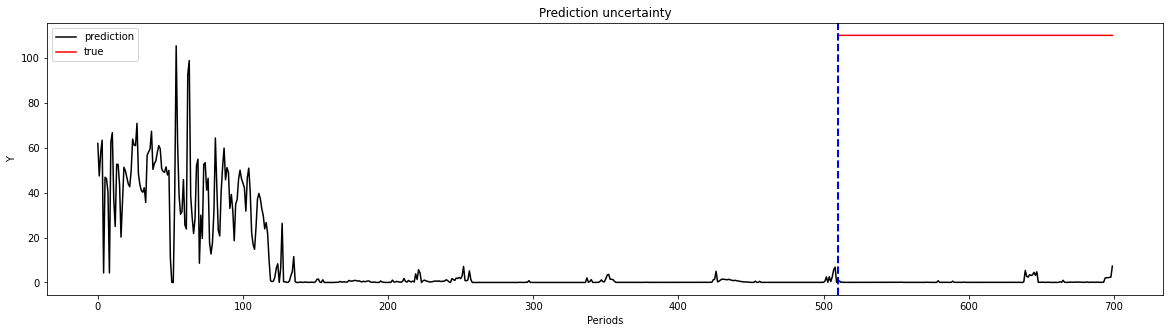

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 89.74s | valid loss 0.03442 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   3 |    16/   84 batches | lr 0.004706 | 969.01 ms | loss 0.07571 | ppl     1.08
| epoch   3 |    32/   84 batches | lr 0.004706 | 904.11 ms | loss 0.08208 | ppl     1.09
| epoch   3 |    48/   84 batches | lr 0.004706 | 908.47 ms | loss 0.01782 | ppl     1.02
| epoch   3 |    64/   84 batches | lr 0.004706 | 969.74 ms | loss 0.00652 | ppl     1.01
| epoch   3 |    80/   84 batches | lr 0.004706 | 931.32 ms | loss 0.00124 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


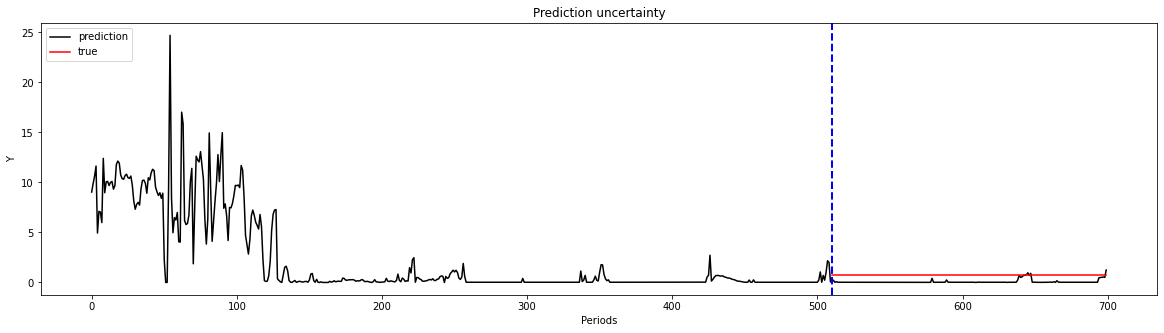

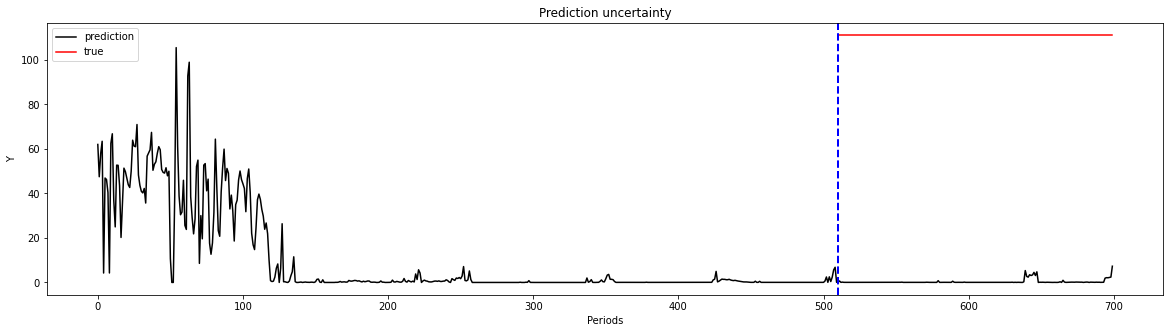

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 89.72s | valid loss 0.03449 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   4 |    16/   84 batches | lr 0.004612 | 973.43 ms | loss 0.07654 | ppl     1.08
| epoch   4 |    32/   84 batches | lr 0.004612 | 902.55 ms | loss 0.07827 | ppl     1.08
| epoch   4 |    48/   84 batches | lr 0.004612 | 933.24 ms | loss 0.01720 | ppl     1.02
| epoch   4 |    64/   84 batches | lr 0.004612 | 964.50 ms | loss 0.00634 | ppl     1.01
| epoch   4 |    80/   84 batches | lr 0.004612 | 935.93 ms | loss 0.00123 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


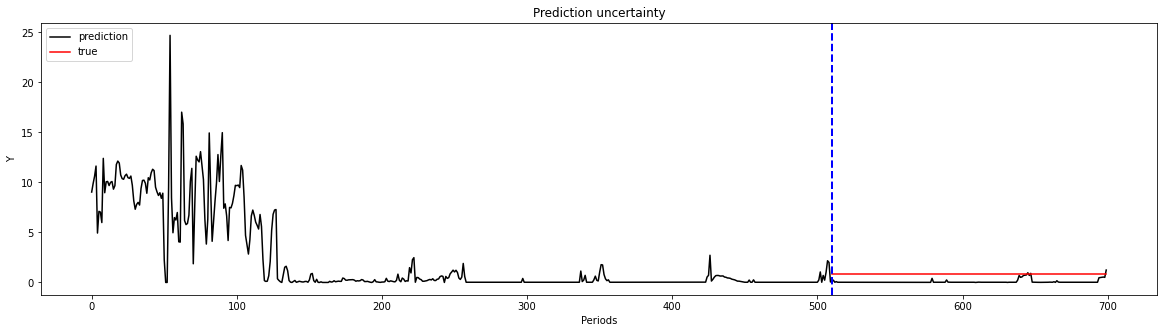

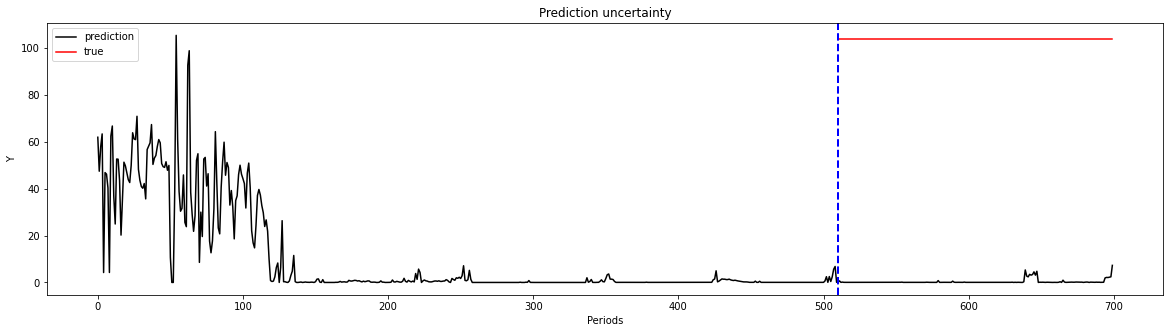

-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 89.95s | valid loss 0.03451 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   5 |    16/   84 batches | lr 0.004520 | 971.72 ms | loss 0.07763 | ppl     1.08
| epoch   5 |    32/   84 batches | lr 0.004520 | 899.98 ms | loss 0.07460 | ppl     1.08
| epoch   5 |    48/   84 batches | lr 0.004520 | 916.84 ms | loss 0.01655 | ppl     1.02
| epoch   5 |    64/   84 batches | lr 0.004520 | 943.04 ms | loss 0.00615 | ppl     1.01
| epoch   5 |    80/   84 batches | lr 0.004520 | 980.14 ms | loss 0.00126 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


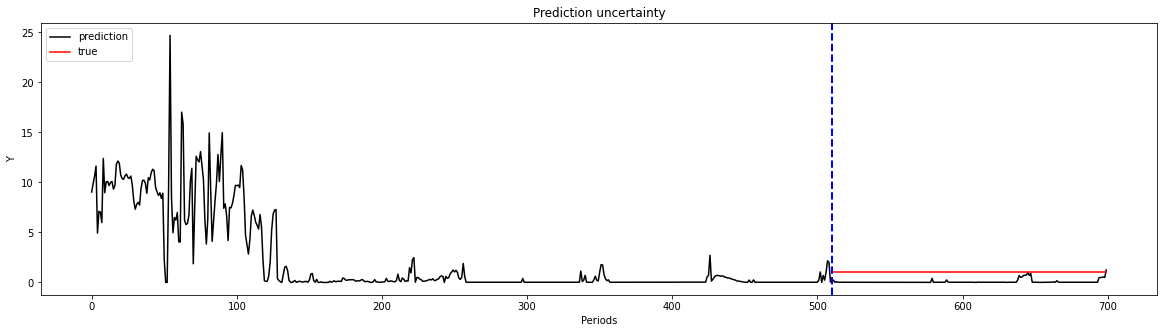

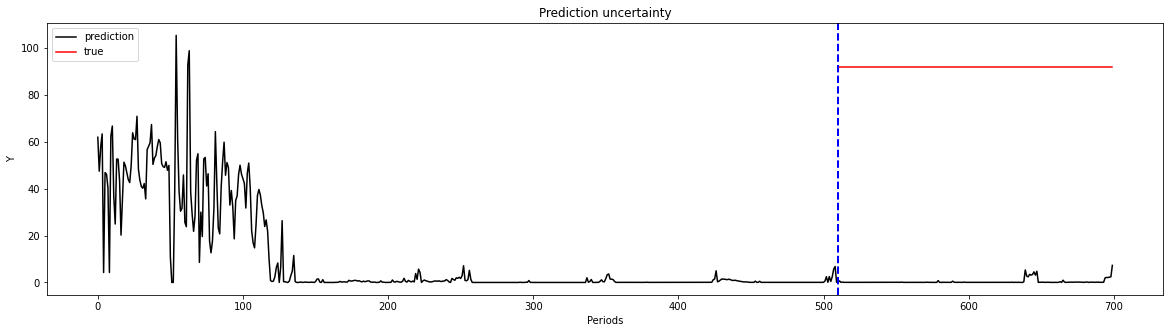

-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 91.77s | valid loss 0.03454 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   6 |    16/   84 batches | lr 0.004429 | 1023.28 ms | loss 0.07895 | ppl     1.08
| epoch   6 |    32/   84 batches | lr 0.004429 | 954.19 ms | loss 0.07115 | ppl     1.07
| epoch   6 |    48/   84 batches | lr 0.004429 | 919.20 ms | loss 0.01594 | ppl     1.02
| epoch   6 |    64/   84 batches | lr 0.004429 | 889.06 ms | loss 0.00596 | ppl     1.01
| epoch   6 |    80/   84 batches | lr 0.004429 | 874.22 ms | loss 0.00130 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


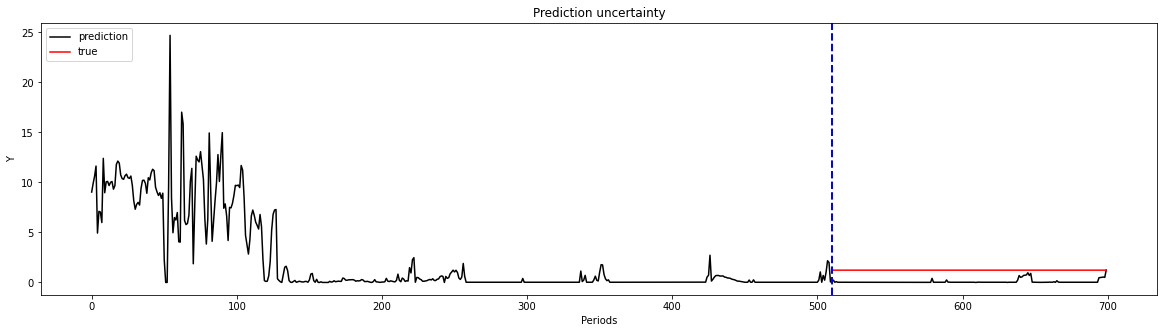

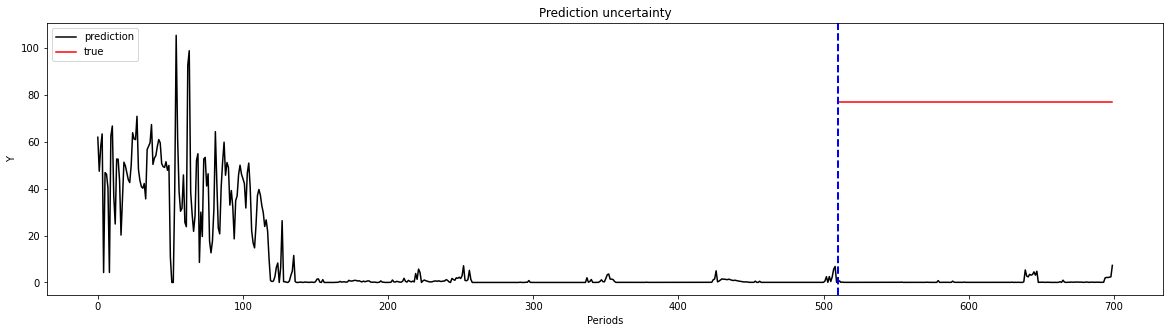

-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 88.64s | valid loss 0.03459 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   7 |    16/   84 batches | lr 0.004341 | 965.49 ms | loss 0.08041 | ppl     1.08
| epoch   7 |    32/   84 batches | lr 0.004341 | 905.77 ms | loss 0.06793 | ppl     1.07
| epoch   7 |    48/   84 batches | lr 0.004341 | 908.22 ms | loss 0.01537 | ppl     1.02
| epoch   7 |    64/   84 batches | lr 0.004341 | 908.41 ms | loss 0.00577 | ppl     1.01
| epoch   7 |    80/   84 batches | lr 0.004341 | 911.47 ms | loss 0.00136 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


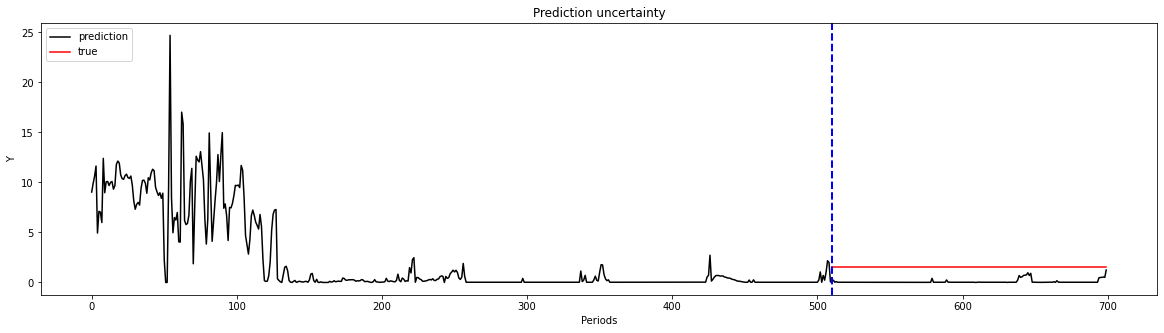

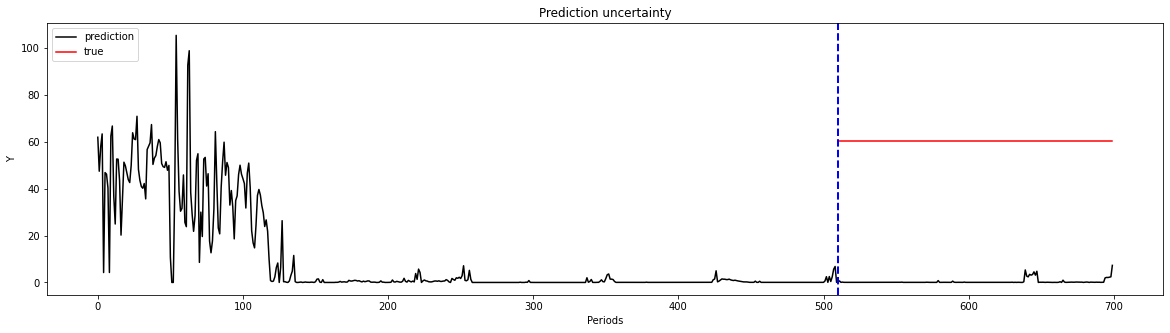

-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 88.90s | valid loss 0.03465 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   8 |    16/   84 batches | lr 0.004254 | 959.13 ms | loss 0.08197 | ppl     1.09
| epoch   8 |    32/   84 batches | lr 0.004254 | 904.49 ms | loss 0.06488 | ppl     1.07
| epoch   8 |    48/   84 batches | lr 0.004254 | 911.58 ms | loss 0.01481 | ppl     1.01
| epoch   8 |    64/   84 batches | lr 0.004254 | 909.59 ms | loss 0.00559 | ppl     1.01
| epoch   8 |    80/   84 batches | lr 0.004254 | 903.00 ms | loss 0.00141 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


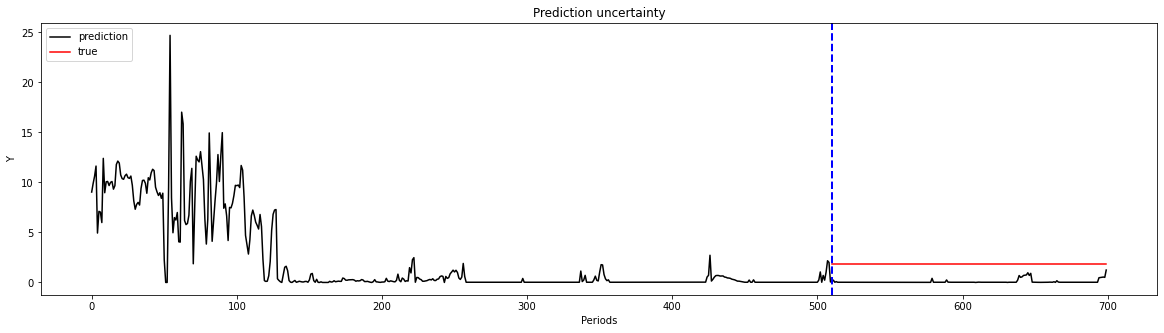

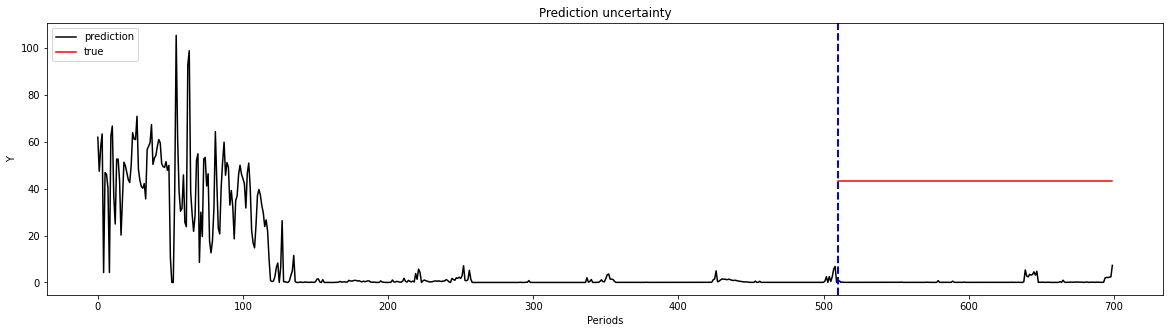

-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 88.70s | valid loss 0.03471 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   9 |    16/   84 batches | lr 0.004169 | 1003.18 ms | loss 0.08359 | ppl     1.09
| epoch   9 |    32/   84 batches | lr 0.004169 | 934.34 ms | loss 0.06191 | ppl     1.06
| epoch   9 |    48/   84 batches | lr 0.004169 | 901.39 ms | loss 0.01426 | ppl     1.01
| epoch   9 |    64/   84 batches | lr 0.004169 | 905.00 ms | loss 0.00543 | ppl     1.01
| epoch   9 |    80/   84 batches | lr 0.004169 | 904.10 ms | loss 0.00145 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


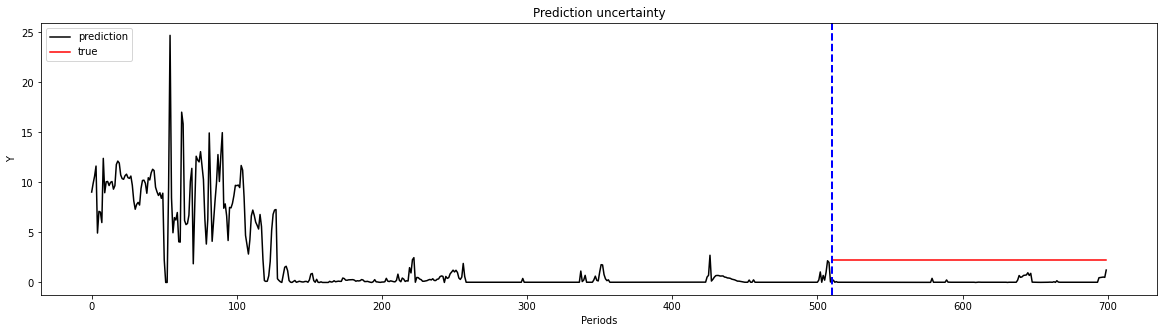

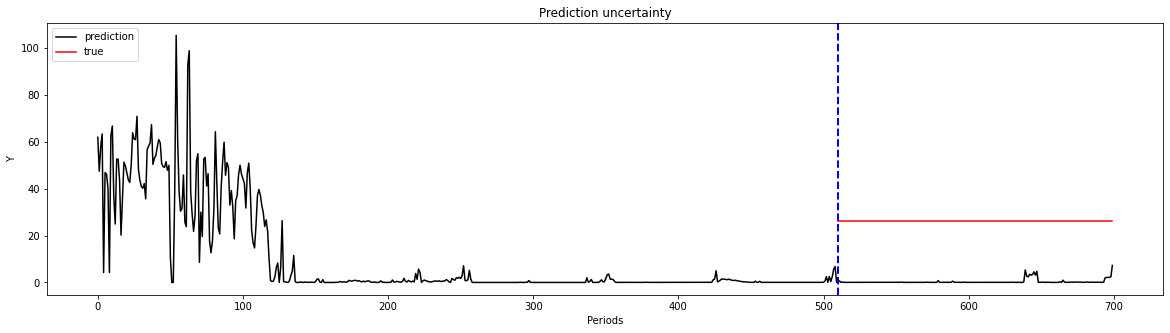

-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 89.77s | valid loss 0.03478 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  10 |    16/   84 batches | lr 0.004085 | 997.74 ms | loss 0.08525 | ppl     1.09
| epoch  10 |    32/   84 batches | lr 0.004085 | 916.11 ms | loss 0.05904 | ppl     1.06
| epoch  10 |    48/   84 batches | lr 0.004085 | 893.81 ms | loss 0.01371 | ppl     1.01
| epoch  10 |    64/   84 batches | lr 0.004085 | 908.72 ms | loss 0.00528 | ppl     1.01
| epoch  10 |    80/   84 batches | lr 0.004085 | 928.58 ms | loss 0.00149 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


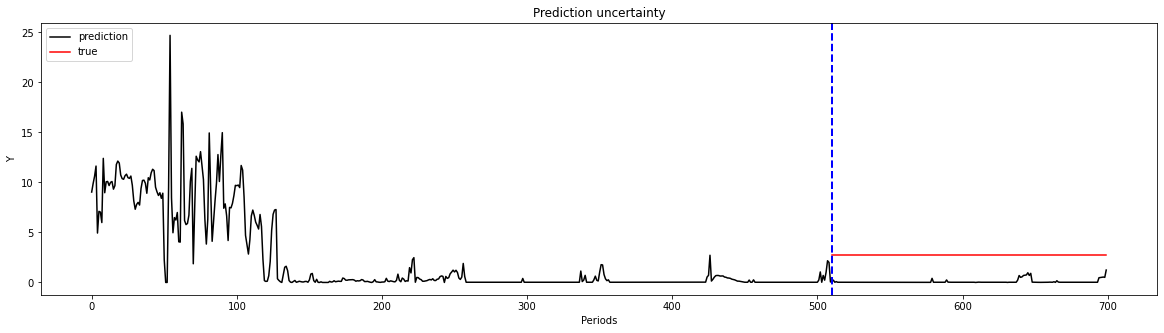

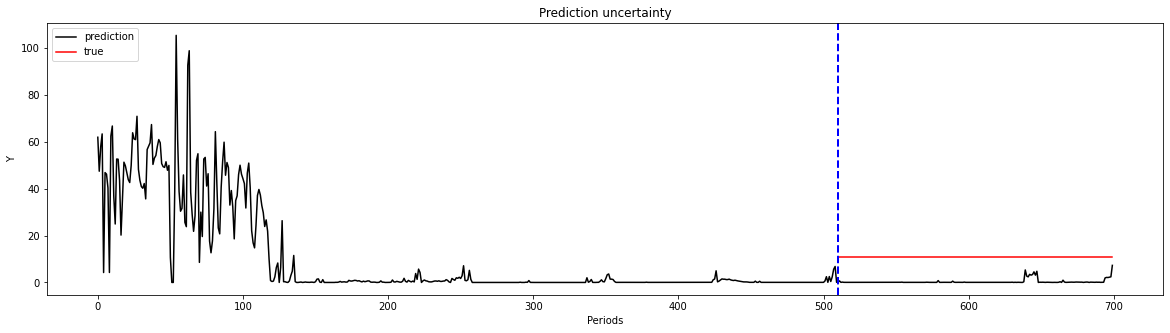

-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 89.40s | valid loss 0.03483 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  11 |    16/   84 batches | lr 0.004004 | 1009.92 ms | loss 0.08689 | ppl     1.09
| epoch  11 |    32/   84 batches | lr 0.004004 | 903.35 ms | loss 0.05630 | ppl     1.06
| epoch  11 |    48/   84 batches | lr 0.004004 | 904.74 ms | loss 0.01318 | ppl     1.01
| epoch  11 |    64/   84 batches | lr 0.004004 | 902.07 ms | loss 0.00516 | ppl     1.01
| epoch  11 |    80/   84 batches | lr 0.004004 | 903.03 ms | loss 0.00151 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


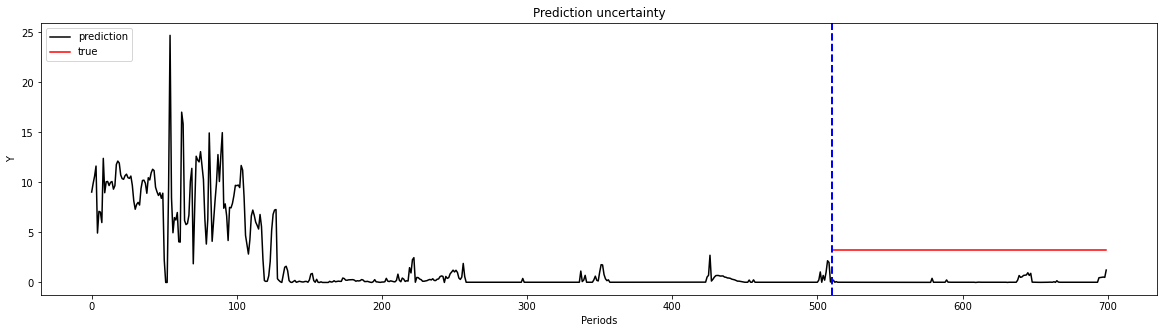

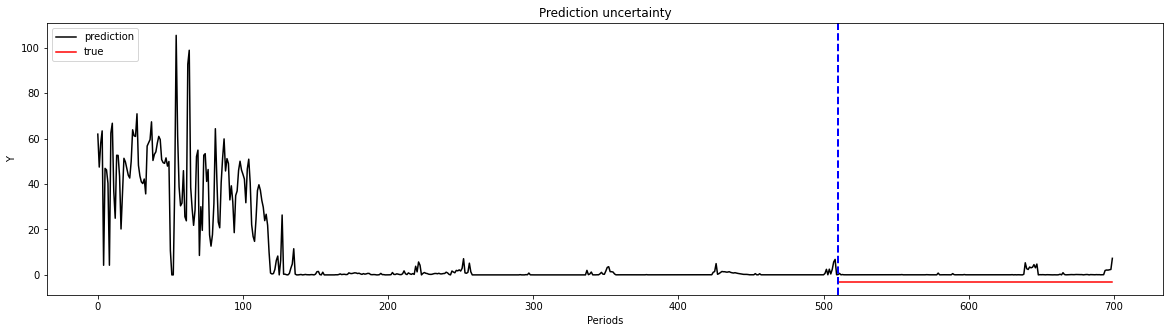

-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 88.80s | valid loss 0.03488 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  12 |    16/   84 batches | lr 0.003924 | 1032.41 ms | loss 0.08849 | ppl     1.09
| epoch  12 |    32/   84 batches | lr 0.003924 | 902.10 ms | loss 0.05370 | ppl     1.06
| epoch  12 |    48/   84 batches | lr 0.003924 | 916.93 ms | loss 0.01267 | ppl     1.01
| epoch  12 |    64/   84 batches | lr 0.003924 | 912.44 ms | loss 0.00506 | ppl     1.01
| epoch  12 |    80/   84 batches | lr 0.003924 | 908.38 ms | loss 0.00152 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


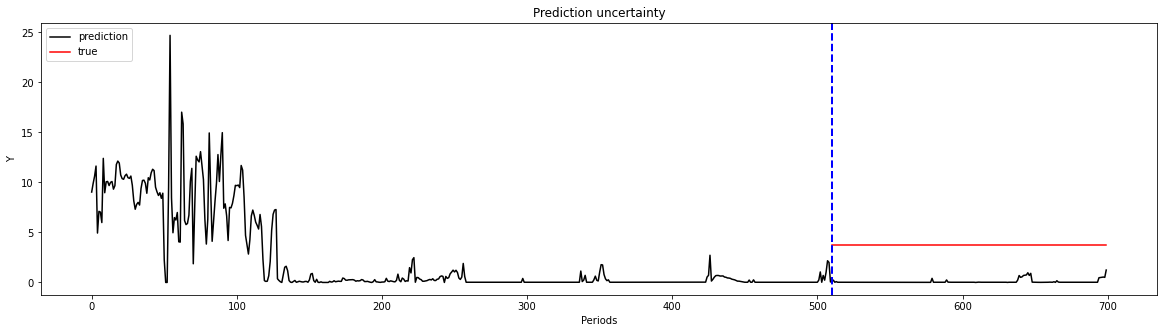

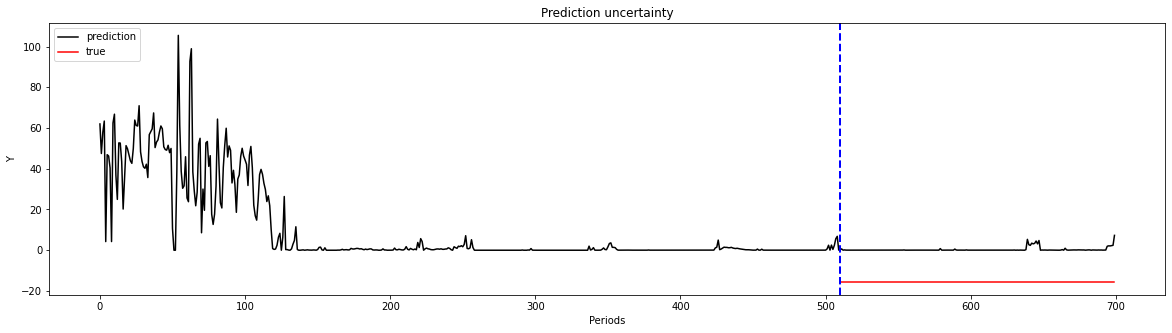

-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 88.97s | valid loss 0.03492 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  13 |    16/   84 batches | lr 0.003845 | 1044.98 ms | loss 0.09004 | ppl     1.09
| epoch  13 |    32/   84 batches | lr 0.003845 | 917.89 ms | loss 0.05126 | ppl     1.05
| epoch  13 |    48/   84 batches | lr 0.003845 | 899.64 ms | loss 0.01220 | ppl     1.01
| epoch  13 |    64/   84 batches | lr 0.003845 | 901.72 ms | loss 0.00498 | ppl     1.00
| epoch  13 |    80/   84 batches | lr 0.003845 | 906.18 ms | loss 0.00152 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


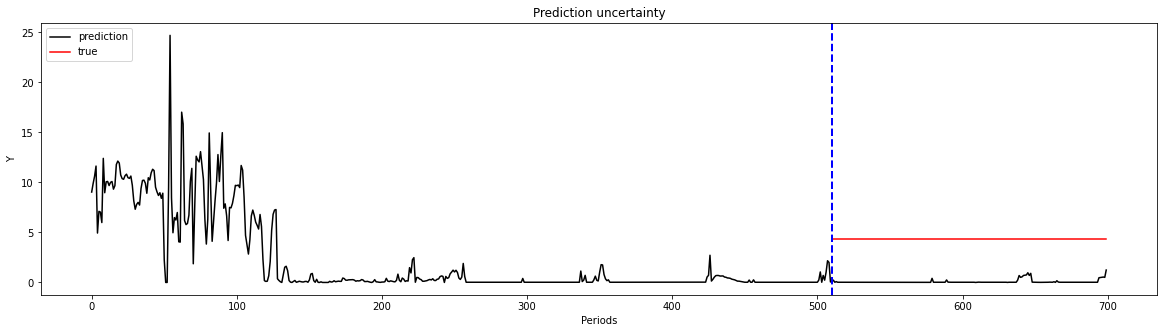

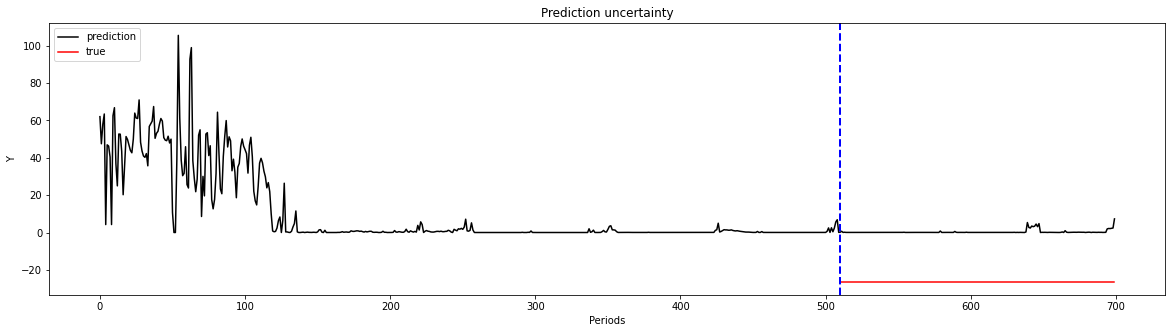

-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 91.09s | valid loss 0.03496 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  14 |    16/   84 batches | lr 0.003768 | 1043.03 ms | loss 0.09151 | ppl     1.10
| epoch  14 |    32/   84 batches | lr 0.003768 | 940.66 ms | loss 0.04902 | ppl     1.05
| epoch  14 |    48/   84 batches | lr 0.003768 | 907.91 ms | loss 0.01179 | ppl     1.01
| epoch  14 |    64/   84 batches | lr 0.003768 | 909.67 ms | loss 0.00491 | ppl     1.00
| epoch  14 |    80/   84 batches | lr 0.003768 | 895.42 ms | loss 0.00150 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


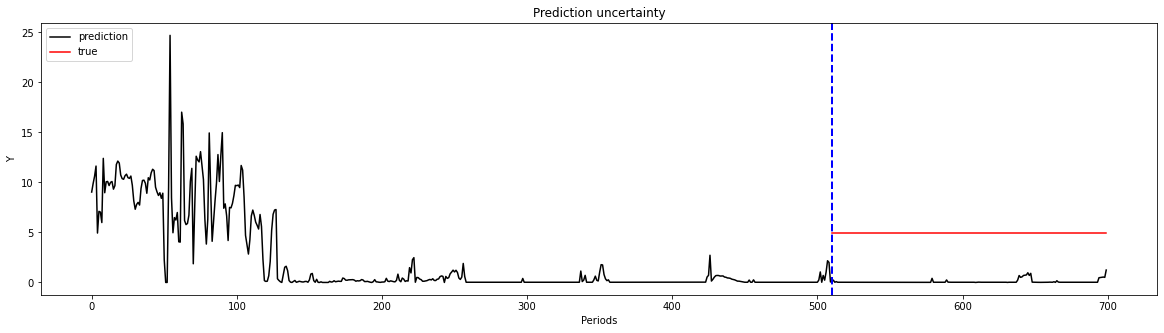

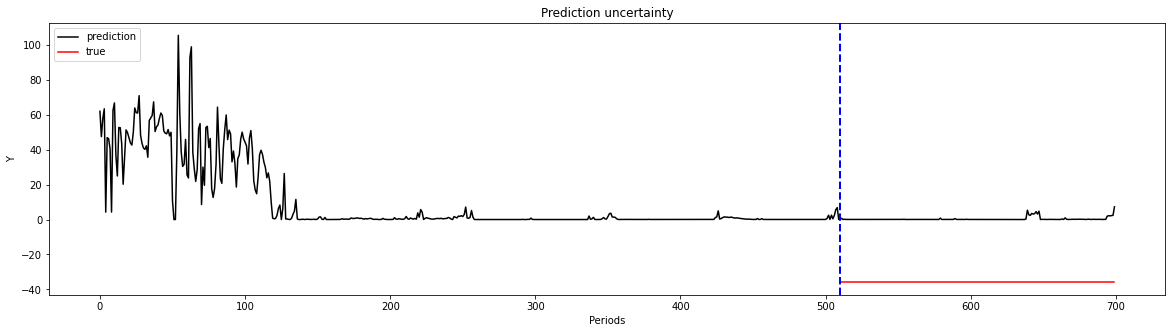

-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 89.20s | valid loss 0.03499 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  15 |    16/   84 batches | lr 0.003693 | 984.89 ms | loss 0.09290 | ppl     1.10
| epoch  15 |    32/   84 batches | lr 0.003693 | 953.93 ms | loss 0.04704 | ppl     1.05
| epoch  15 |    48/   84 batches | lr 0.003693 | 905.83 ms | loss 0.01146 | ppl     1.01
| epoch  15 |    64/   84 batches | lr 0.003693 | 900.70 ms | loss 0.00487 | ppl     1.00
| epoch  15 |    80/   84 batches | lr 0.003693 | 897.31 ms | loss 0.00148 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


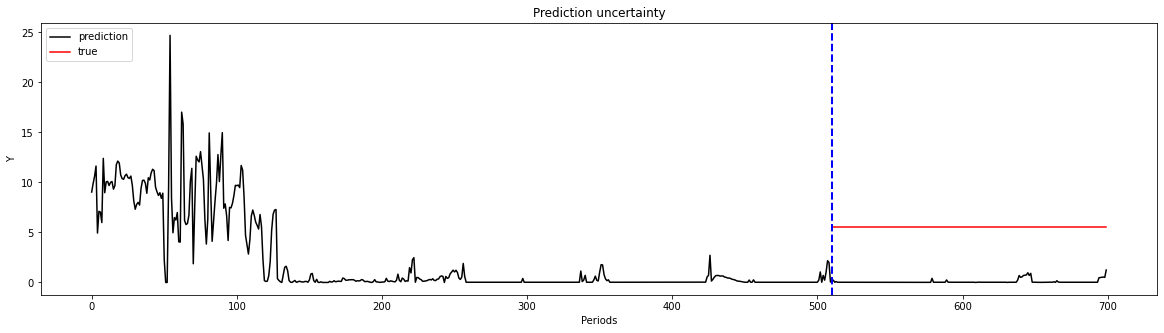

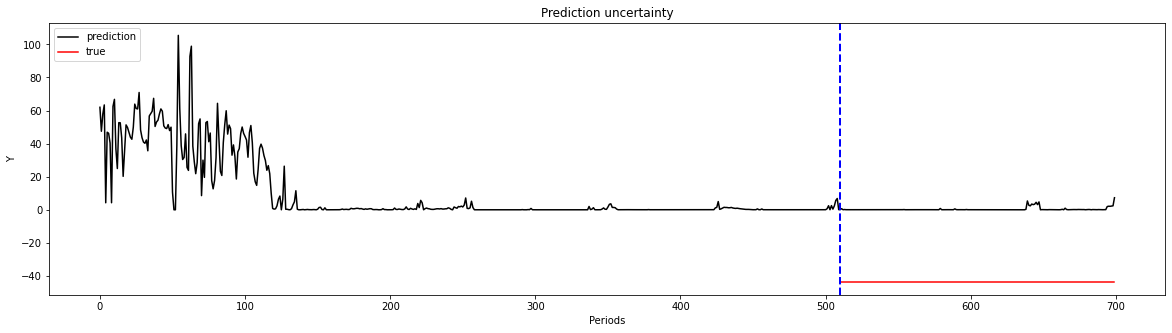

-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 89.07s | valid loss 0.03501 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  16 |    16/   84 batches | lr 0.003619 | 967.71 ms | loss 0.09421 | ppl     1.10
| epoch  16 |    32/   84 batches | lr 0.003619 | 975.86 ms | loss 0.04521 | ppl     1.05
| epoch  16 |    48/   84 batches | lr 0.003619 | 910.08 ms | loss 0.01115 | ppl     1.01
| epoch  16 |    64/   84 batches | lr 0.003619 | 908.67 ms | loss 0.00484 | ppl     1.00
| epoch  16 |    80/   84 batches | lr 0.003619 | 908.38 ms | loss 0.00144 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


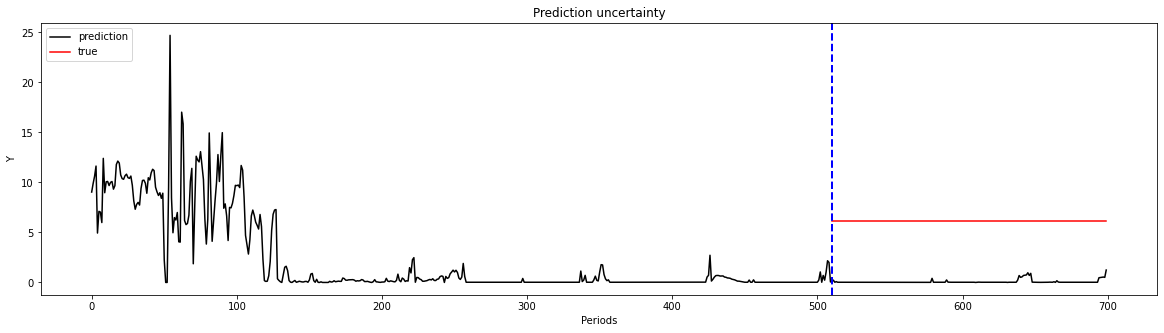

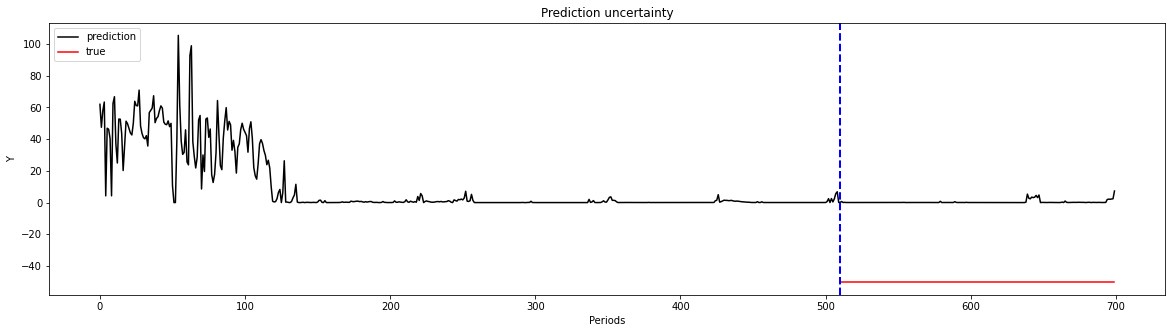

-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 88.97s | valid loss 0.03503 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  17 |    16/   84 batches | lr 0.003547 | 955.76 ms | loss 0.09543 | ppl     1.10
| epoch  17 |    32/   84 batches | lr 0.003547 | 884.79 ms | loss 0.04353 | ppl     1.04
| epoch  17 |    48/   84 batches | lr 0.003547 | 875.87 ms | loss 0.01089 | ppl     1.01
| epoch  17 |    64/   84 batches | lr 0.003547 | 912.96 ms | loss 0.00483 | ppl     1.00
| epoch  17 |    80/   84 batches | lr 0.003547 | 903.56 ms | loss 0.00140 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


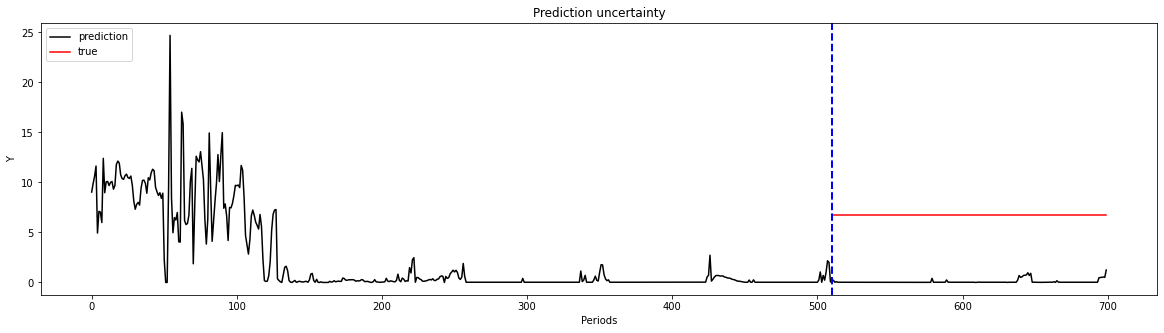

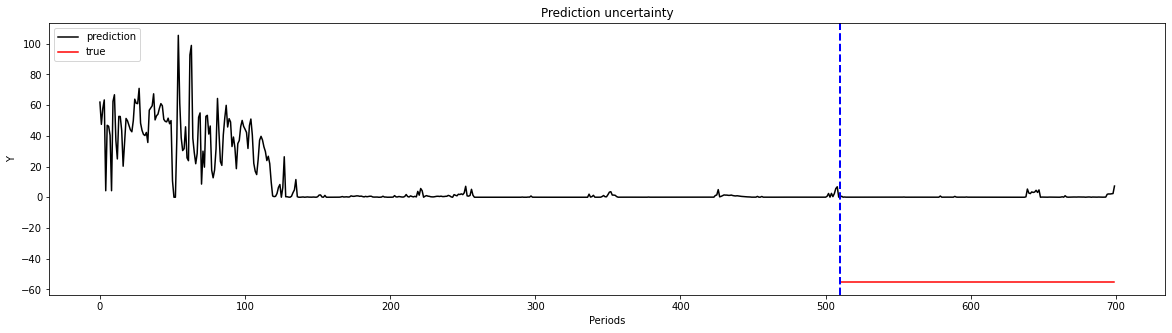

-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 86.77s | valid loss 0.03505 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  18 |    16/   84 batches | lr 0.003476 | 962.53 ms | loss 0.09658 | ppl     1.10
| epoch  18 |    32/   84 batches | lr 0.003476 | 907.55 ms | loss 0.04207 | ppl     1.04
| epoch  18 |    48/   84 batches | lr 0.003476 | 944.47 ms | loss 0.01070 | ppl     1.01
| epoch  18 |    64/   84 batches | lr 0.003476 | 951.90 ms | loss 0.00483 | ppl     1.00
| epoch  18 |    80/   84 batches | lr 0.003476 | 955.36 ms | loss 0.00136 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


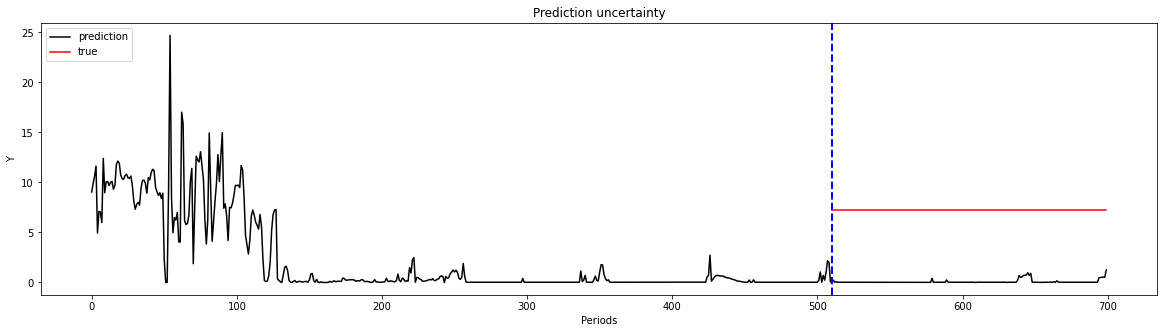

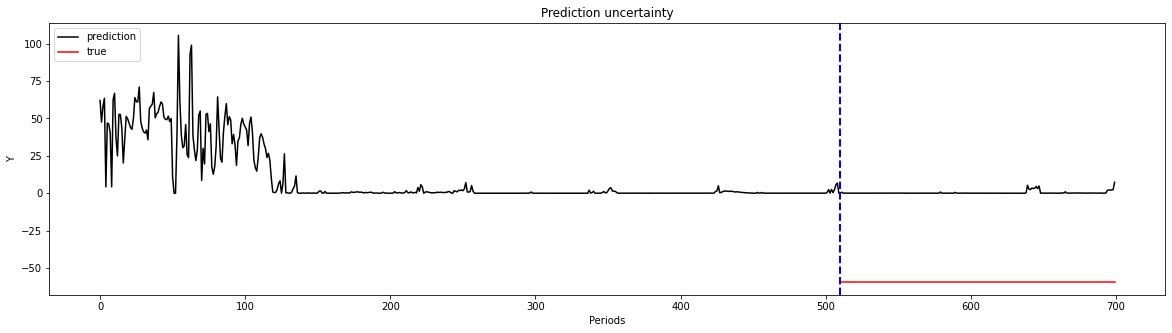

-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 91.64s | valid loss 0.03506 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  19 |    16/   84 batches | lr 0.003406 | 967.64 ms | loss 0.09764 | ppl     1.10
| epoch  19 |    32/   84 batches | lr 0.003406 | 927.72 ms | loss 0.04082 | ppl     1.04
| epoch  19 |    48/   84 batches | lr 0.003406 | 1006.65 ms | loss 0.01058 | ppl     1.01
| epoch  19 |    64/   84 batches | lr 0.003406 | 1004.30 ms | loss 0.00485 | ppl     1.00
| epoch  19 |    80/   84 batches | lr 0.003406 | 1014.06 ms | loss 0.00130 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


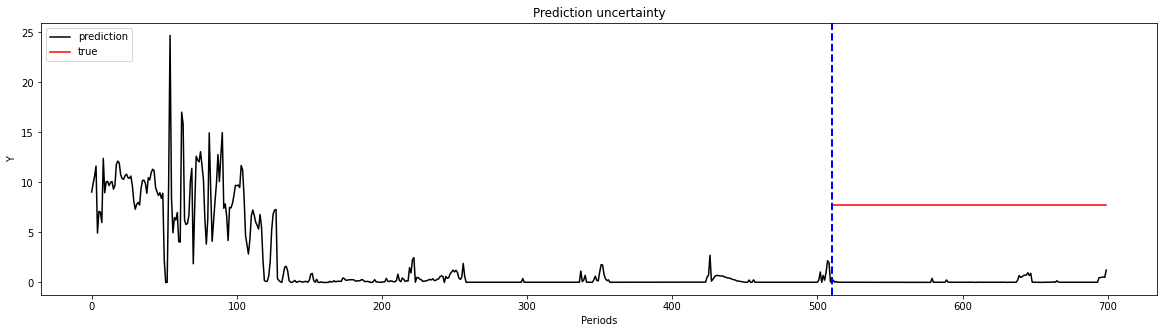

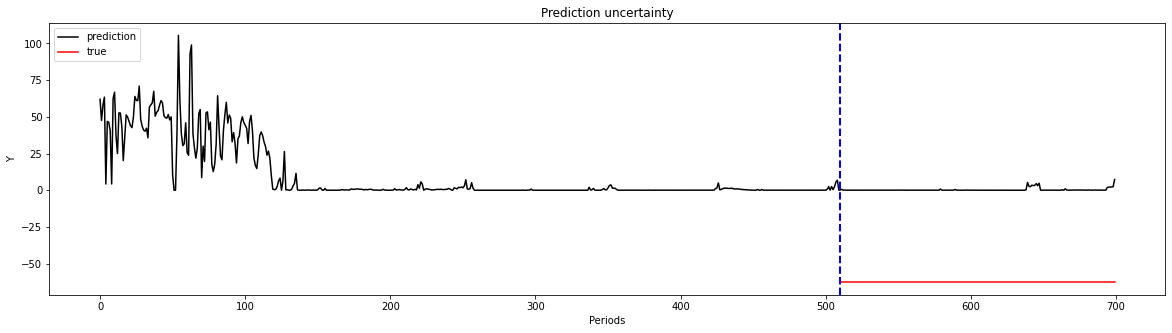

-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 94.94s | valid loss 0.03507 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  20 |    16/   84 batches | lr 0.003338 | 974.94 ms | loss 0.09864 | ppl     1.10
| epoch  20 |    32/   84 batches | lr 0.003338 | 902.51 ms | loss 0.03980 | ppl     1.04
| epoch  20 |    48/   84 batches | lr 0.003338 | 914.21 ms | loss 0.01057 | ppl     1.01
| epoch  20 |    64/   84 batches | lr 0.003338 | 972.92 ms | loss 0.00489 | ppl     1.00
| epoch  20 |    80/   84 batches | lr 0.003338 | 908.46 ms | loss 0.00124 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


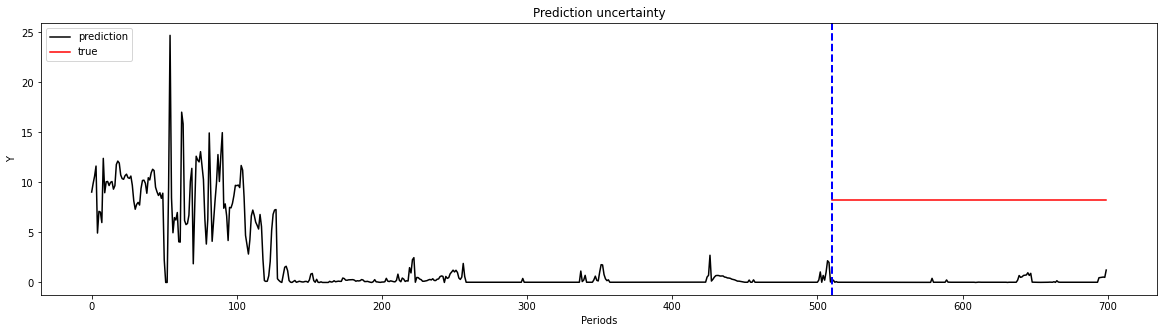

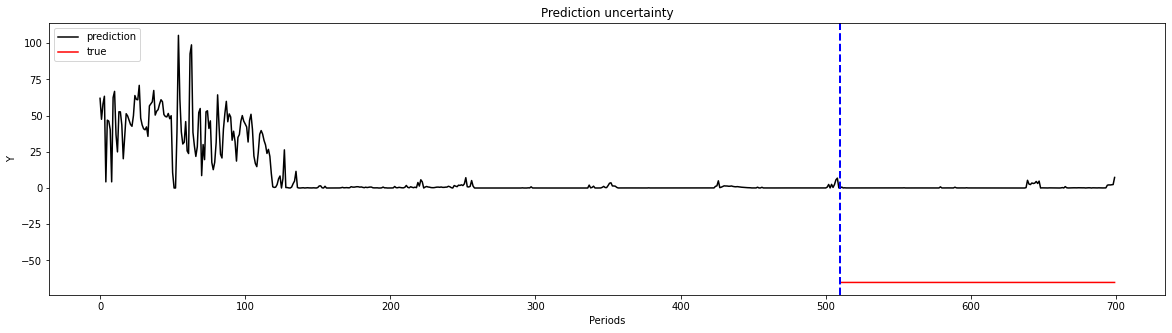

-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 88.82s | valid loss 0.03508 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  21 |    16/   84 batches | lr 0.003271 | 967.95 ms | loss 0.09957 | ppl     1.10
| epoch  21 |    32/   84 batches | lr 0.003271 | 913.58 ms | loss 0.03884 | ppl     1.04
| epoch  21 |    48/   84 batches | lr 0.003271 | 916.47 ms | loss 0.01054 | ppl     1.01
| epoch  21 |    64/   84 batches | lr 0.003271 | 961.42 ms | loss 0.00494 | ppl     1.00
| epoch  21 |    80/   84 batches | lr 0.003271 | 921.44 ms | loss 0.00118 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


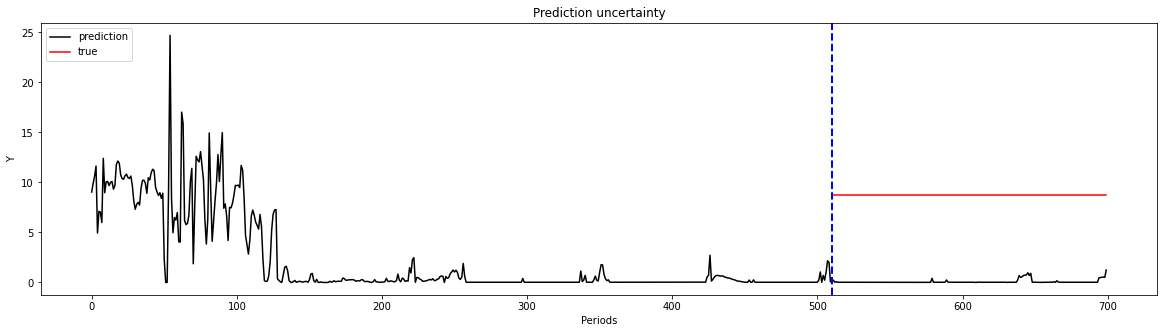

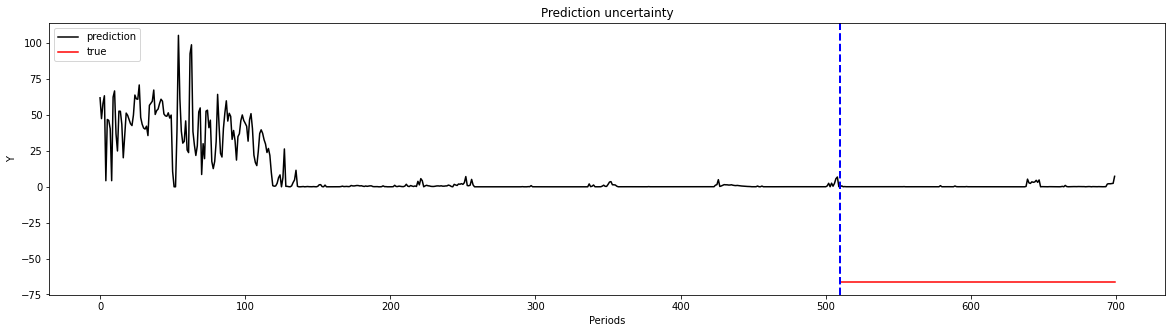

-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 89.03s | valid loss 0.03509 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  22 |    16/   84 batches | lr 0.003206 | 955.74 ms | loss 0.10042 | ppl     1.11
| epoch  22 |    32/   84 batches | lr 0.003206 | 907.12 ms | loss 0.03794 | ppl     1.04
| epoch  22 |    48/   84 batches | lr 0.003206 | 891.21 ms | loss 0.01050 | ppl     1.01
| epoch  22 |    64/   84 batches | lr 0.003206 | 935.65 ms | loss 0.00499 | ppl     1.01
| epoch  22 |    80/   84 batches | lr 0.003206 | 950.03 ms | loss 0.00112 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


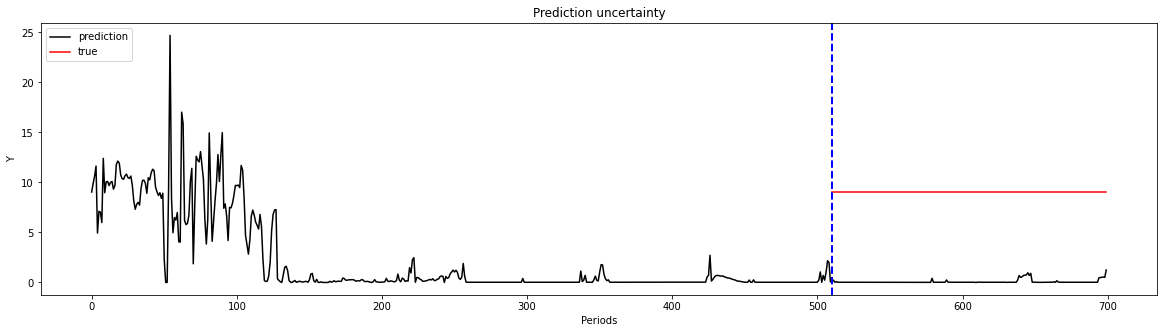

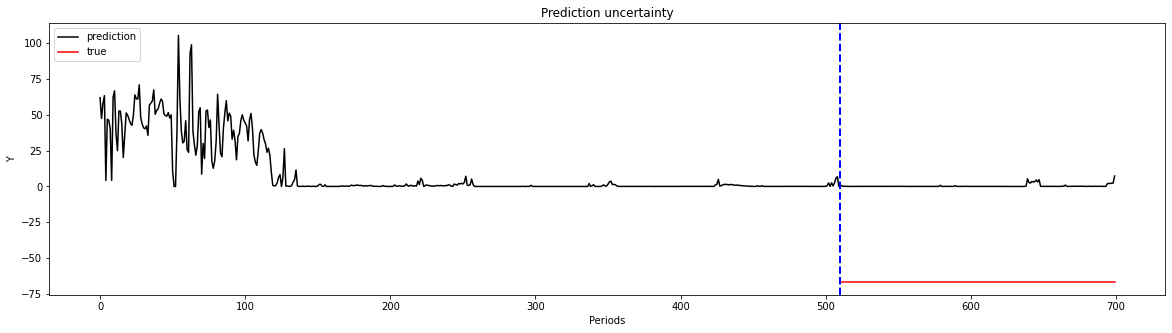

-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 88.37s | valid loss 0.03509 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  23 |    16/   84 batches | lr 0.003142 | 952.33 ms | loss 0.10121 | ppl     1.11
| epoch  23 |    32/   84 batches | lr 0.003142 | 921.89 ms | loss 0.03711 | ppl     1.04
| epoch  23 |    48/   84 batches | lr 0.003142 | 926.48 ms | loss 0.01046 | ppl     1.01
| epoch  23 |    64/   84 batches | lr 0.003142 | 908.77 ms | loss 0.00505 | ppl     1.01
| epoch  23 |    80/   84 batches | lr 0.003142 | 969.14 ms | loss 0.00106 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


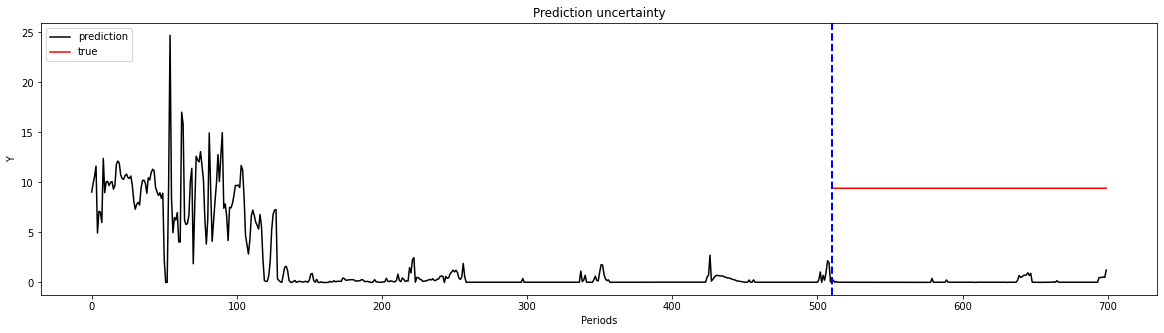

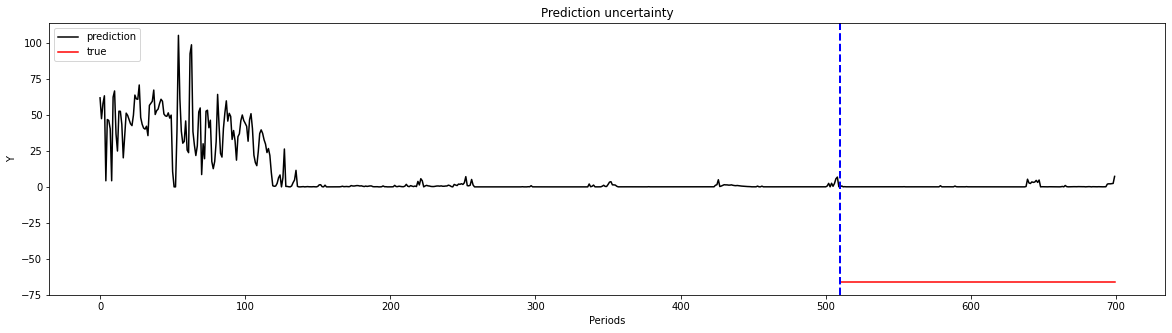

-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 89.03s | valid loss 0.03508 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  24 |    16/   84 batches | lr 0.003079 | 968.79 ms | loss 0.10195 | ppl     1.11
| epoch  24 |    32/   84 batches | lr 0.003079 | 902.39 ms | loss 0.03632 | ppl     1.04
| epoch  24 |    48/   84 batches | lr 0.003079 | 903.56 ms | loss 0.01040 | ppl     1.01
| epoch  24 |    64/   84 batches | lr 0.003079 | 908.76 ms | loss 0.00511 | ppl     1.01
| epoch  24 |    80/   84 batches | lr 0.003079 | 946.19 ms | loss 0.00100 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


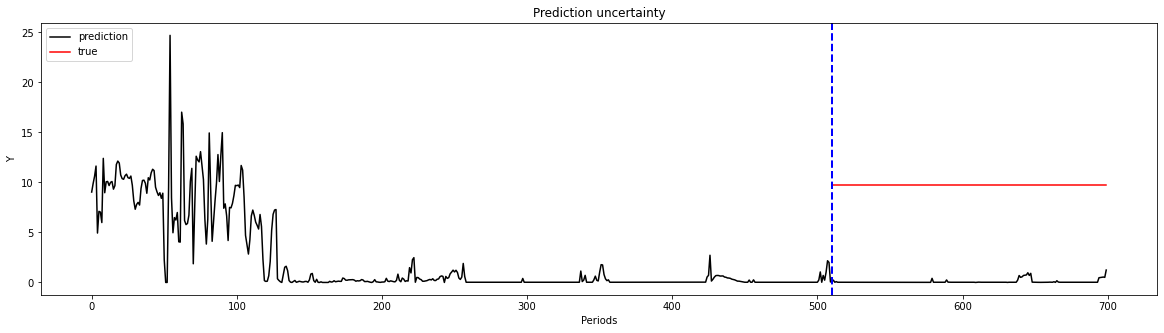

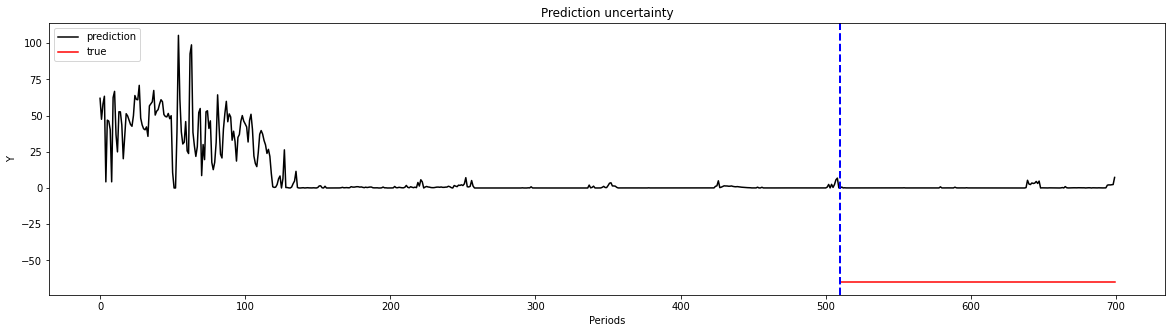

-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 88.82s | valid loss 0.03507 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  25 |    16/   84 batches | lr 0.003017 | 952.30 ms | loss 0.10262 | ppl     1.11
| epoch  25 |    32/   84 batches | lr 0.003017 | 900.29 ms | loss 0.03558 | ppl     1.04
| epoch  25 |    48/   84 batches | lr 0.003017 | 914.29 ms | loss 0.01034 | ppl     1.01
| epoch  25 |    64/   84 batches | lr 0.003017 | 912.78 ms | loss 0.00517 | ppl     1.01
| epoch  25 |    80/   84 batches | lr 0.003017 | 919.17 ms | loss 0.00095 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


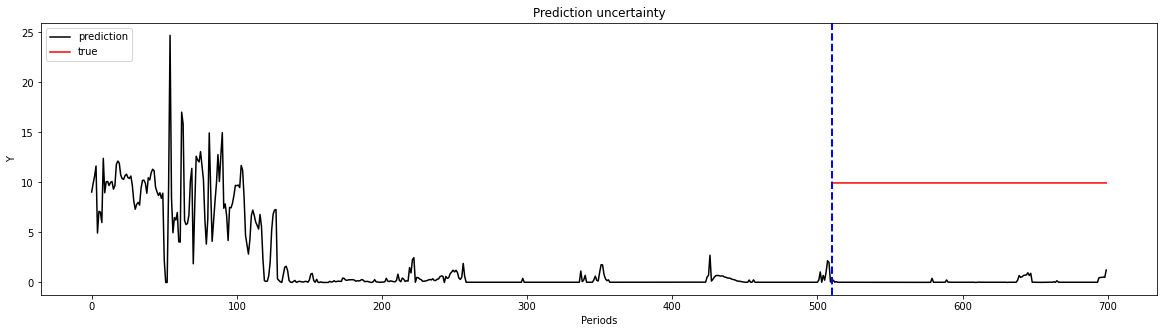

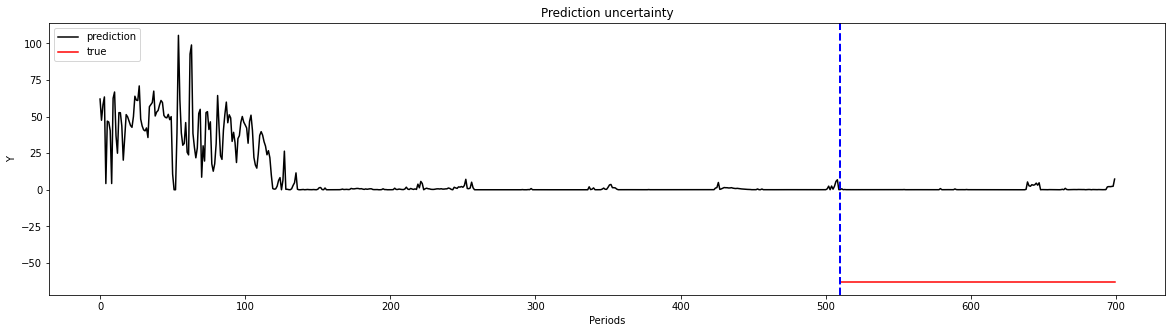

-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 88.67s | valid loss 0.03505 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  26 |    16/   84 batches | lr 0.002957 | 976.77 ms | loss 0.10325 | ppl     1.11
| epoch  26 |    32/   84 batches | lr 0.002957 | 912.20 ms | loss 0.03489 | ppl     1.04
| epoch  26 |    48/   84 batches | lr 0.002957 | 907.76 ms | loss 0.01027 | ppl     1.01
| epoch  26 |    64/   84 batches | lr 0.002957 | 915.67 ms | loss 0.00523 | ppl     1.01
| epoch  26 |    80/   84 batches | lr 0.002957 | 908.69 ms | loss 0.00090 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


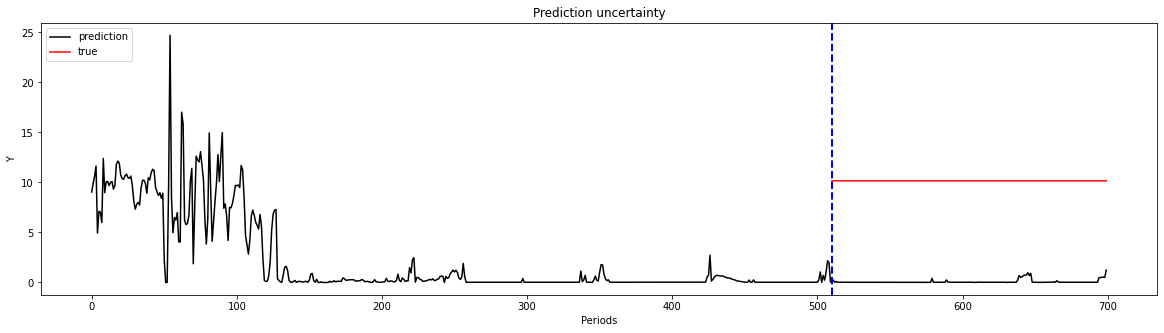

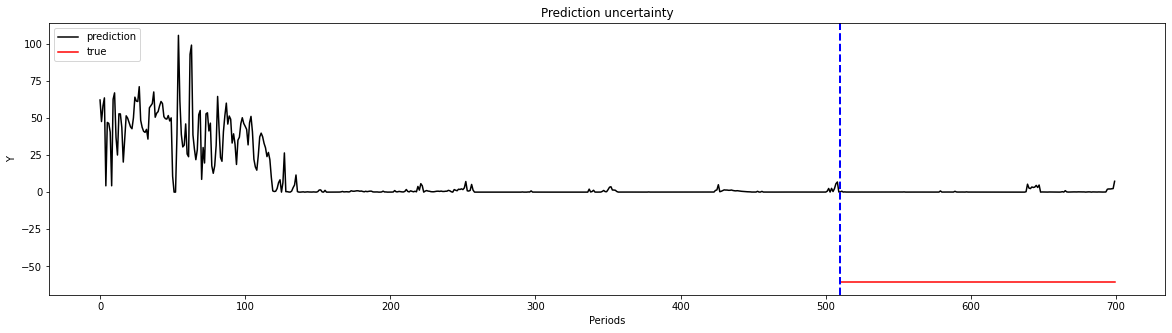

-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 89.50s | valid loss 0.03503 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  27 |    16/   84 batches | lr 0.002898 | 963.60 ms | loss 0.10383 | ppl     1.11
| epoch  27 |    32/   84 batches | lr 0.002898 | 904.03 ms | loss 0.03423 | ppl     1.03
| epoch  27 |    48/   84 batches | lr 0.002898 | 907.79 ms | loss 0.01020 | ppl     1.01
| epoch  27 |    64/   84 batches | lr 0.002898 | 909.65 ms | loss 0.00530 | ppl     1.01
| epoch  27 |    80/   84 batches | lr 0.002898 | 902.54 ms | loss 0.00085 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


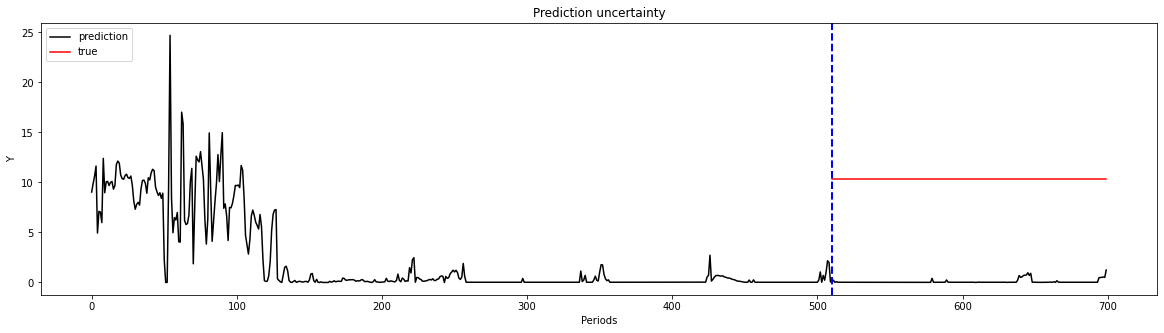

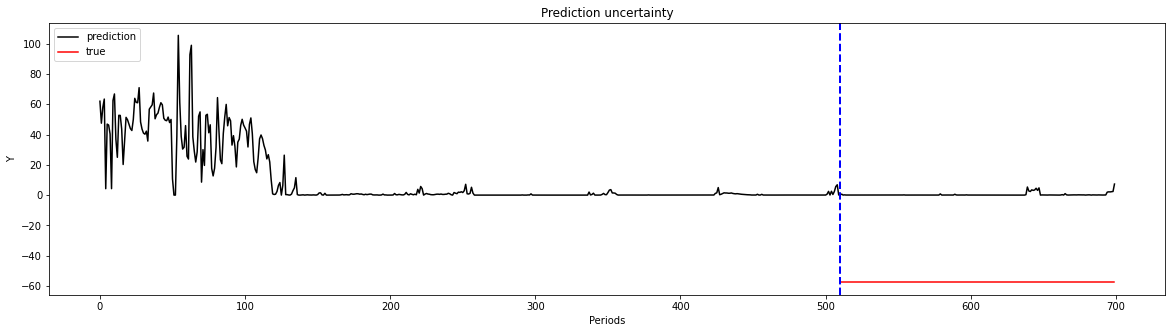

-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 87.60s | valid loss 0.03501 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  28 |    16/   84 batches | lr 0.002840 | 931.42 ms | loss 0.10437 | ppl     1.11
| epoch  28 |    32/   84 batches | lr 0.002840 | 901.84 ms | loss 0.03361 | ppl     1.03
| epoch  28 |    48/   84 batches | lr 0.002840 | 948.00 ms | loss 0.01012 | ppl     1.01
| epoch  28 |    64/   84 batches | lr 0.002840 | 955.84 ms | loss 0.00536 | ppl     1.01
| epoch  28 |    80/   84 batches | lr 0.002840 | 913.25 ms | loss 0.00080 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


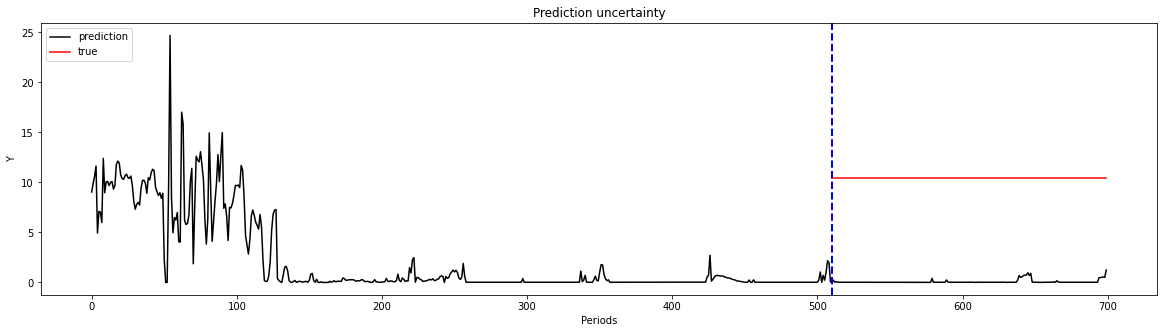

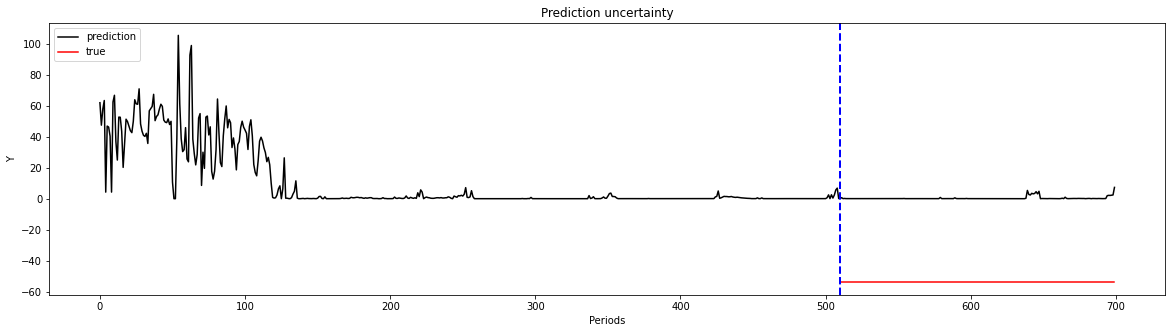

-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 88.62s | valid loss 0.03498 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  29 |    16/   84 batches | lr 0.002783 | 1008.71 ms | loss 0.10487 | ppl     1.11
| epoch  29 |    32/   84 batches | lr 0.002783 | 955.96 ms | loss 0.03301 | ppl     1.03
| epoch  29 |    48/   84 batches | lr 0.002783 | 903.63 ms | loss 0.01004 | ppl     1.01
| epoch  29 |    64/   84 batches | lr 0.002783 | 910.42 ms | loss 0.00542 | ppl     1.01
| epoch  29 |    80/   84 batches | lr 0.002783 | 906.20 ms | loss 0.00076 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


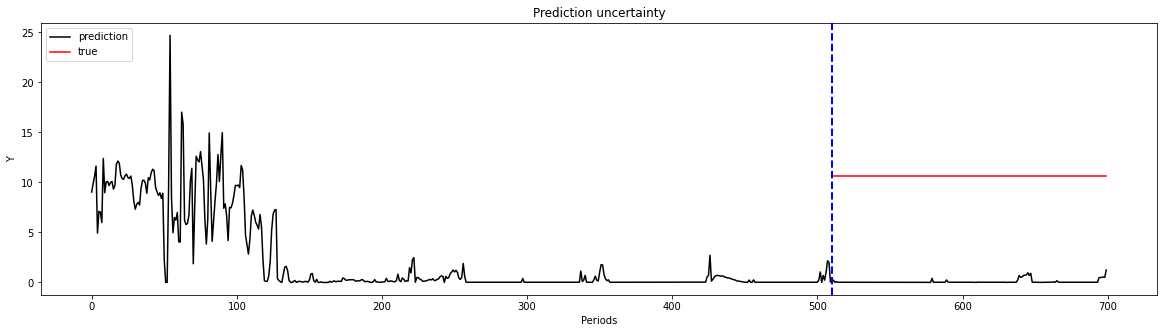

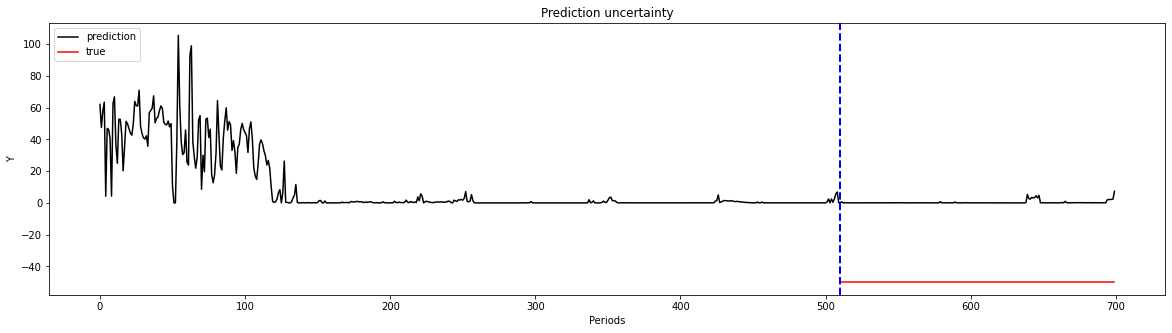

-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 89.20s | valid loss 0.03495 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  30 |    16/   84 batches | lr 0.002727 | 979.09 ms | loss 0.10533 | ppl     1.11
| epoch  30 |    32/   84 batches | lr 0.002727 | 978.77 ms | loss 0.03245 | ppl     1.03
| epoch  30 |    48/   84 batches | lr 0.002727 | 905.31 ms | loss 0.00996 | ppl     1.01
| epoch  30 |    64/   84 batches | lr 0.002727 | 901.70 ms | loss 0.00548 | ppl     1.01
| epoch  30 |    80/   84 batches | lr 0.002727 | 907.47 ms | loss 0.00073 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


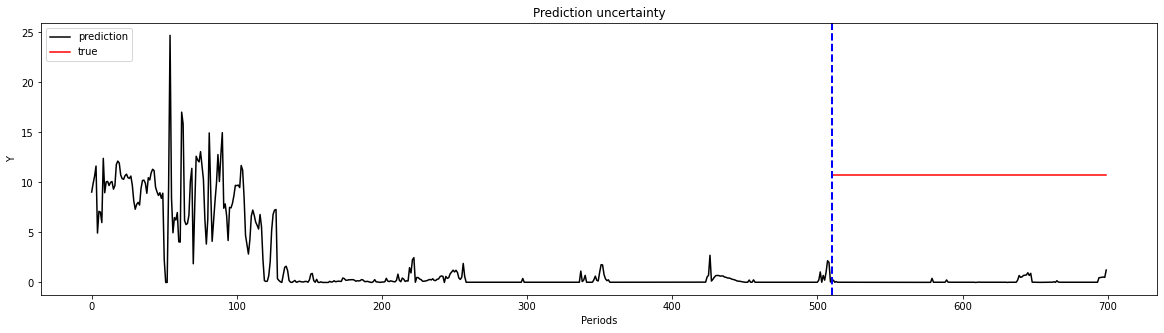

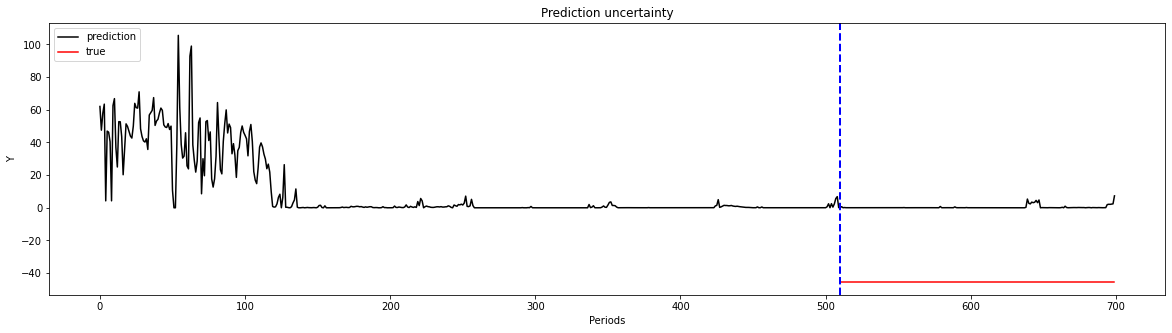

-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 89.32s | valid loss 0.03492 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  31 |    16/   84 batches | lr 0.002673 | 963.30 ms | loss 0.10576 | ppl     1.11
| epoch  31 |    32/   84 batches | lr 0.002673 | 961.01 ms | loss 0.03192 | ppl     1.03
| epoch  31 |    48/   84 batches | lr 0.002673 | 931.64 ms | loss 0.00987 | ppl     1.01
| epoch  31 |    64/   84 batches | lr 0.002673 | 911.67 ms | loss 0.00554 | ppl     1.01
| epoch  31 |    80/   84 batches | lr 0.002673 | 908.29 ms | loss 0.00070 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


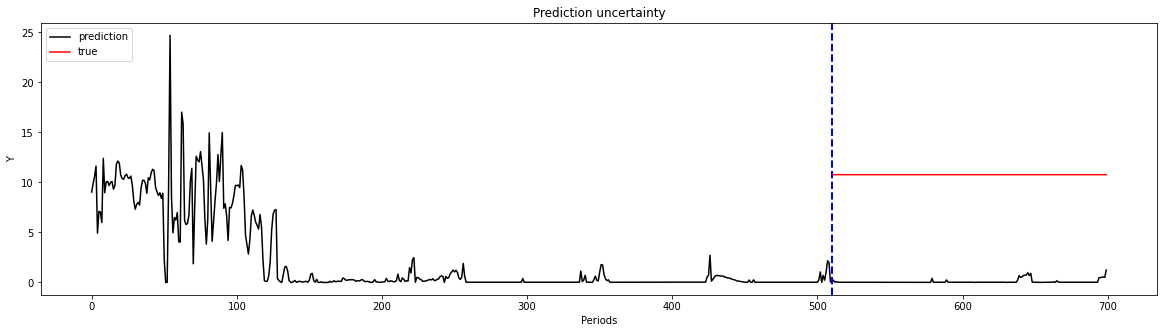

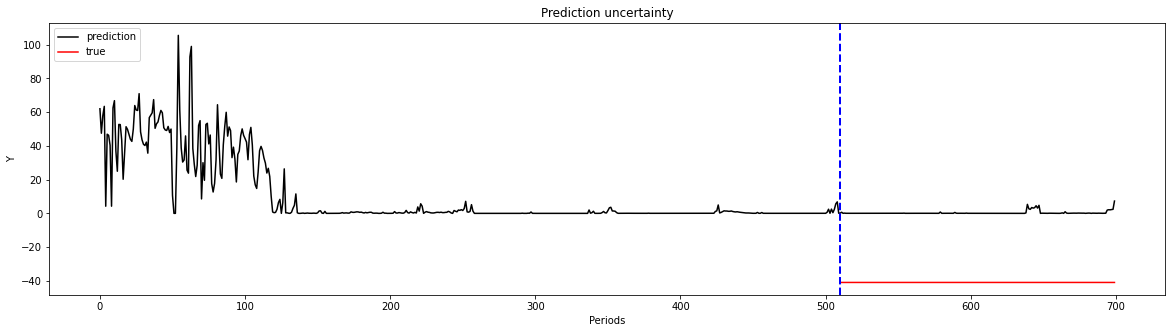

-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 89.04s | valid loss 0.03488 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  32 |    16/   84 batches | lr 0.002619 | 962.52 ms | loss 0.10615 | ppl     1.11
| epoch  32 |    32/   84 batches | lr 0.002619 | 933.16 ms | loss 0.03141 | ppl     1.03
| epoch  32 |    48/   84 batches | lr 0.002619 | 954.73 ms | loss 0.00978 | ppl     1.01
| epoch  32 |    64/   84 batches | lr 0.002619 | 903.02 ms | loss 0.00560 | ppl     1.01
| epoch  32 |    80/   84 batches | lr 0.002619 | 940.16 ms | loss 0.00067 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


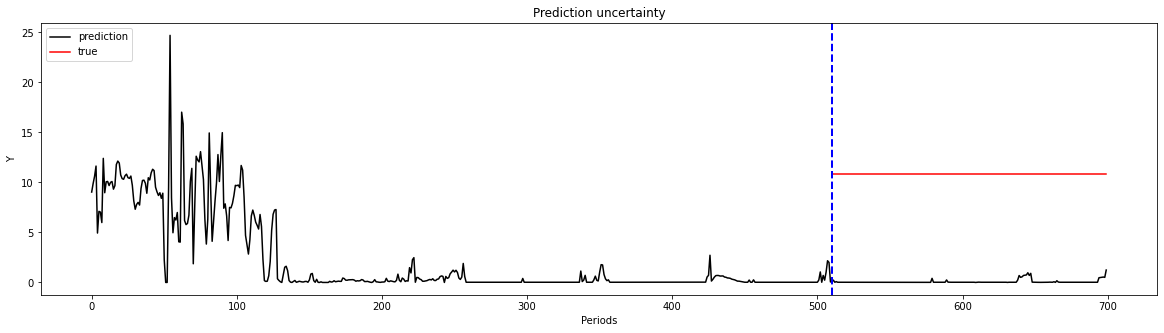

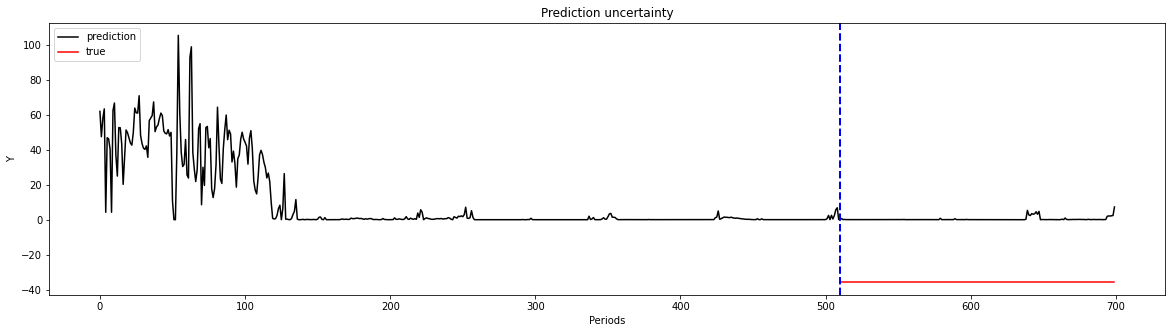

-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 90.83s | valid loss 0.03484 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  33 |    16/   84 batches | lr 0.002567 | 954.12 ms | loss 0.10652 | ppl     1.11
| epoch  33 |    32/   84 batches | lr 0.002567 | 918.16 ms | loss 0.03092 | ppl     1.03
| epoch  33 |    48/   84 batches | lr 0.002567 | 974.93 ms | loss 0.00970 | ppl     1.01
| epoch  33 |    64/   84 batches | lr 0.002567 | 912.61 ms | loss 0.00565 | ppl     1.01
| epoch  33 |    80/   84 batches | lr 0.002567 | 906.93 ms | loss 0.00065 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


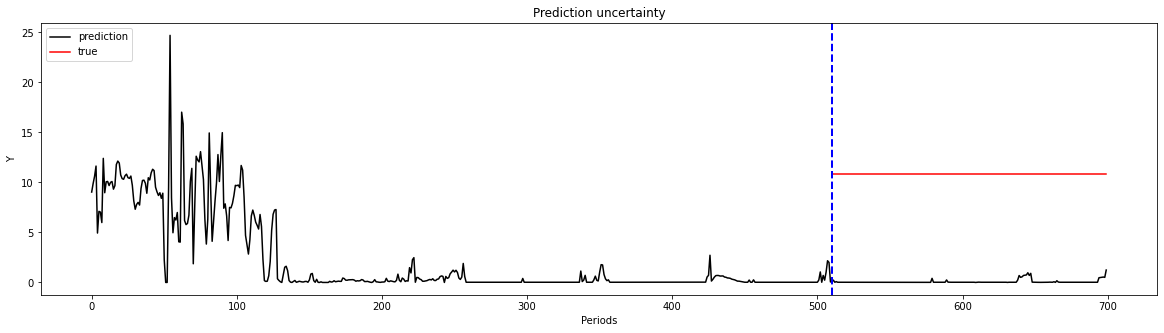

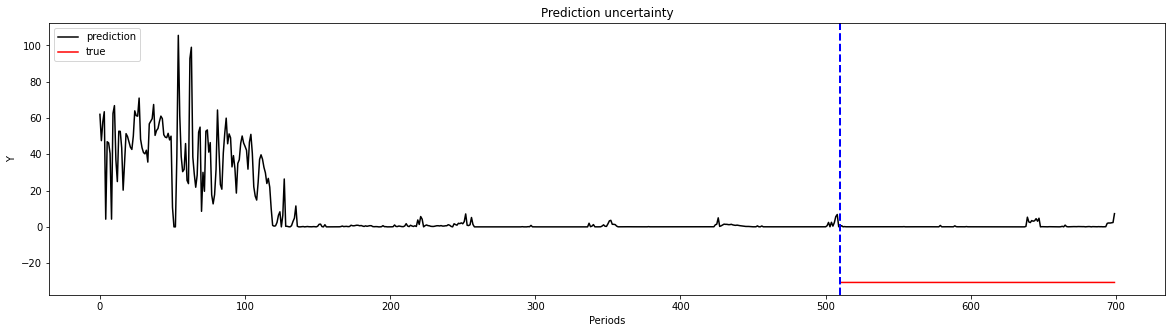

-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 88.68s | valid loss 0.03480 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  34 |    16/   84 batches | lr 0.002516 | 947.53 ms | loss 0.10686 | ppl     1.11
| epoch  34 |    32/   84 batches | lr 0.002516 | 909.68 ms | loss 0.03046 | ppl     1.03
| epoch  34 |    48/   84 batches | lr 0.002516 | 957.35 ms | loss 0.00961 | ppl     1.01
| epoch  34 |    64/   84 batches | lr 0.002516 | 922.36 ms | loss 0.00570 | ppl     1.01
| epoch  34 |    80/   84 batches | lr 0.002516 | 911.73 ms | loss 0.00063 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


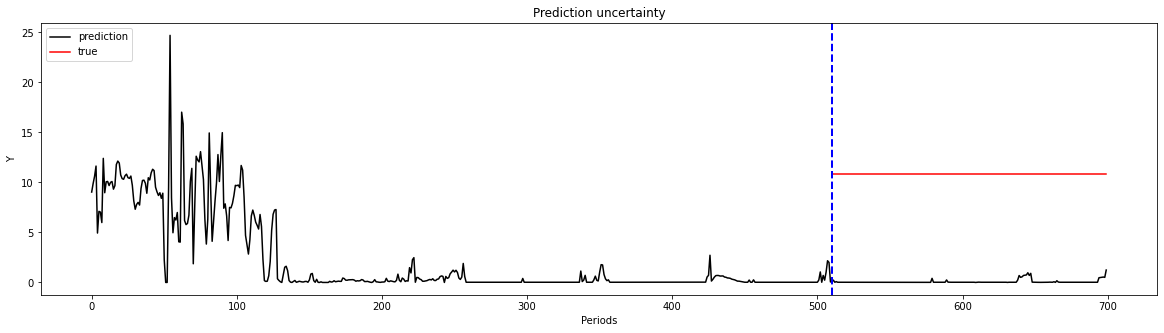

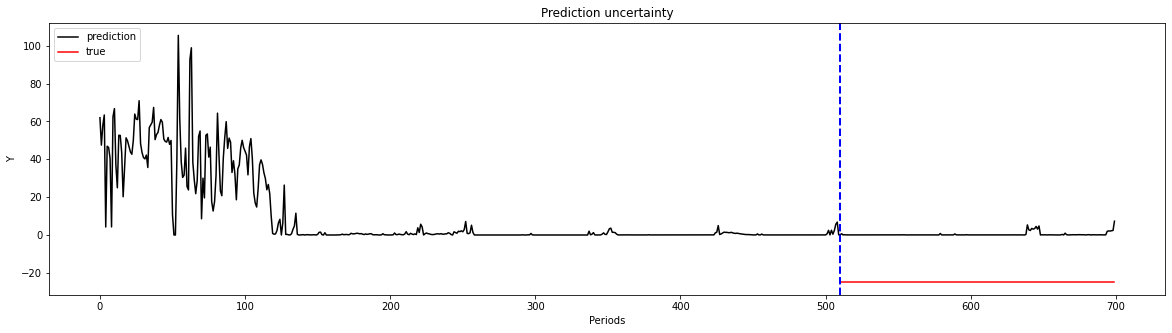

-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 89.06s | valid loss 0.03476 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  35 |    16/   84 batches | lr 0.002465 | 956.13 ms | loss 0.10717 | ppl     1.11
| epoch  35 |    32/   84 batches | lr 0.002465 | 904.29 ms | loss 0.03001 | ppl     1.03
| epoch  35 |    48/   84 batches | lr 0.002465 | 938.45 ms | loss 0.00952 | ppl     1.01
| epoch  35 |    64/   84 batches | lr 0.002465 | 952.43 ms | loss 0.00575 | ppl     1.01
| epoch  35 |    80/   84 batches | lr 0.002465 | 905.44 ms | loss 0.00061 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


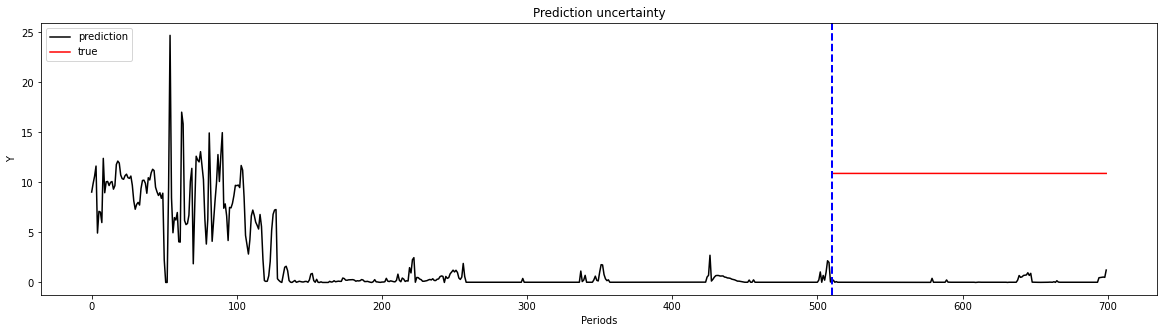

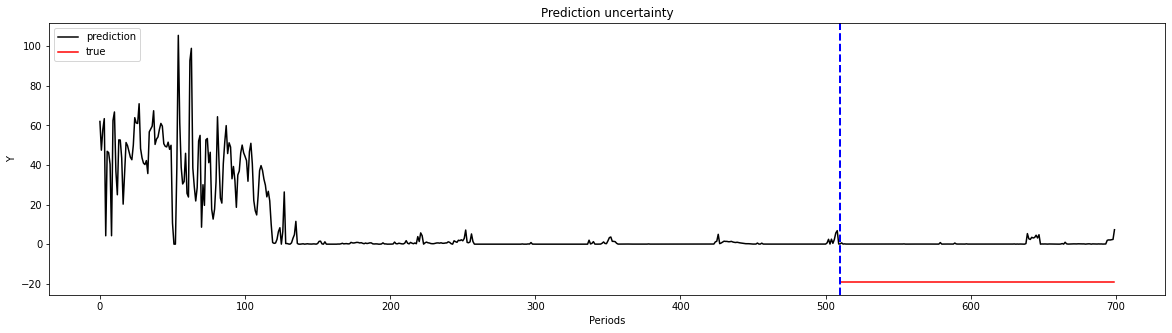

-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 88.69s | valid loss 0.03472 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  36 |    16/   84 batches | lr 0.002416 | 978.50 ms | loss 0.10746 | ppl     1.11
| epoch  36 |    32/   84 batches | lr 0.002416 | 909.66 ms | loss 0.02958 | ppl     1.03
| epoch  36 |    48/   84 batches | lr 0.002416 | 944.00 ms | loss 0.00943 | ppl     1.01
| epoch  36 |    64/   84 batches | lr 0.002416 | 980.82 ms | loss 0.00580 | ppl     1.01
| epoch  36 |    80/   84 batches | lr 0.002416 | 905.62 ms | loss 0.00060 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


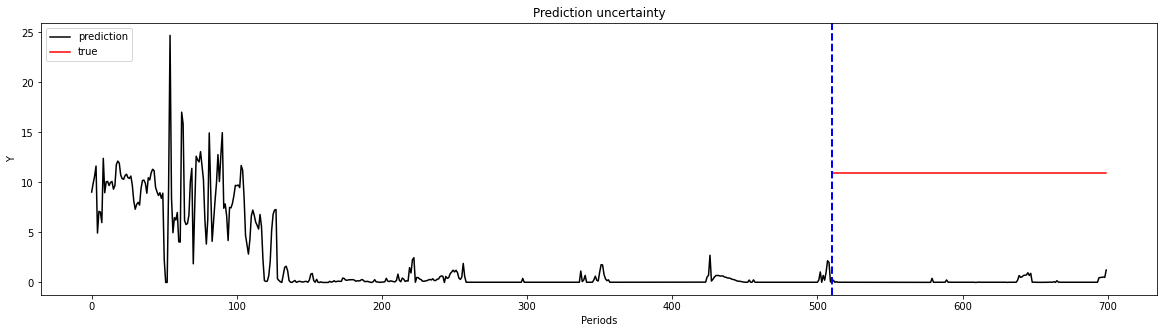

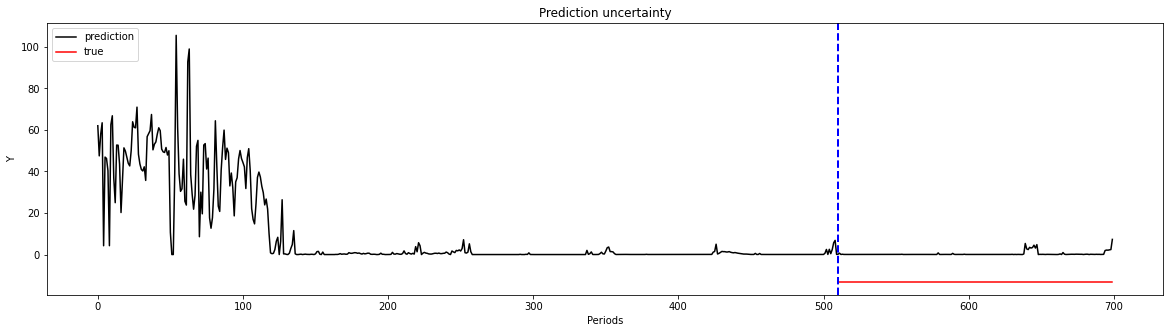

-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 89.63s | valid loss 0.03467 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  37 |    16/   84 batches | lr 0.002368 | 956.84 ms | loss 0.10773 | ppl     1.11
| epoch  37 |    32/   84 batches | lr 0.002368 | 907.49 ms | loss 0.02917 | ppl     1.03
| epoch  37 |    48/   84 batches | lr 0.002368 | 914.79 ms | loss 0.00934 | ppl     1.01
| epoch  37 |    64/   84 batches | lr 0.002368 | 973.39 ms | loss 0.00585 | ppl     1.01
| epoch  37 |    80/   84 batches | lr 0.002368 | 935.75 ms | loss 0.00059 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


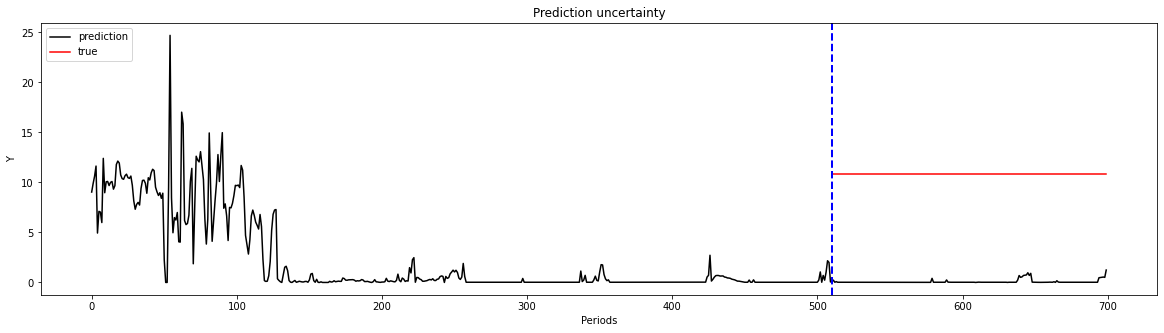

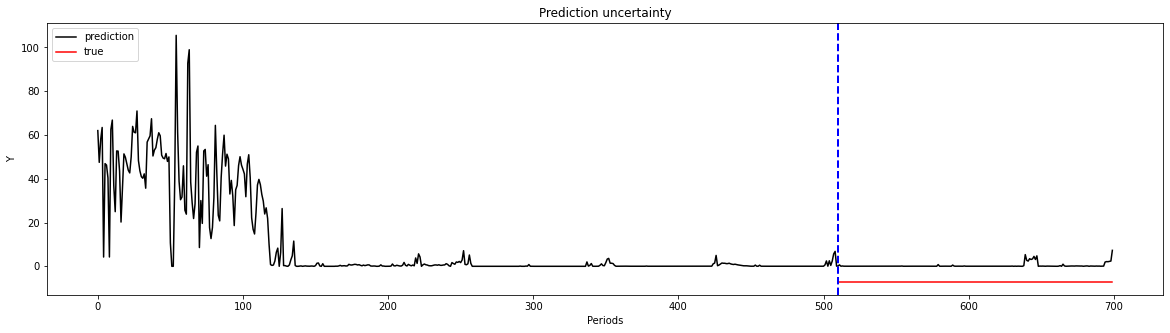

-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 89.54s | valid loss 0.03463 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  38 |    16/   84 batches | lr 0.002320 | 968.51 ms | loss 0.10797 | ppl     1.11
| epoch  38 |    32/   84 batches | lr 0.002320 | 910.33 ms | loss 0.02878 | ppl     1.03
| epoch  38 |    48/   84 batches | lr 0.002320 | 908.88 ms | loss 0.00924 | ppl     1.01
| epoch  38 |    64/   84 batches | lr 0.002320 | 877.58 ms | loss 0.00589 | ppl     1.01
| epoch  38 |    80/   84 batches | lr 0.002320 | 874.75 ms | loss 0.00059 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


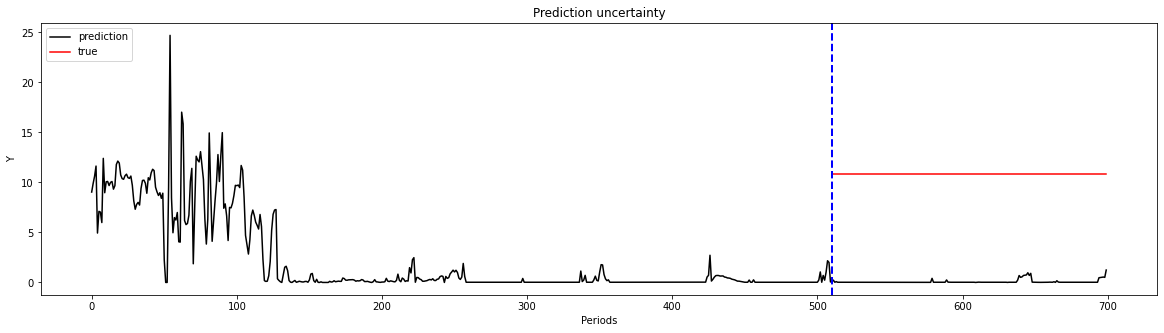

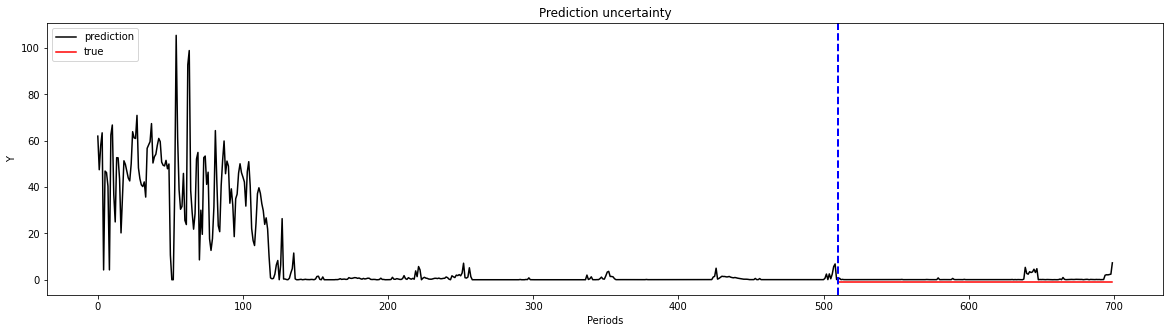

-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 86.95s | valid loss 0.03459 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  39 |    16/   84 batches | lr 0.002274 | 968.76 ms | loss 0.10820 | ppl     1.11
| epoch  39 |    32/   84 batches | lr 0.002274 | 896.87 ms | loss 0.02839 | ppl     1.03
| epoch  39 |    48/   84 batches | lr 0.002274 | 902.52 ms | loss 0.00915 | ppl     1.01
| epoch  39 |    64/   84 batches | lr 0.002274 | 902.87 ms | loss 0.00593 | ppl     1.01
| epoch  39 |    80/   84 batches | lr 0.002274 | 904.73 ms | loss 0.00059 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


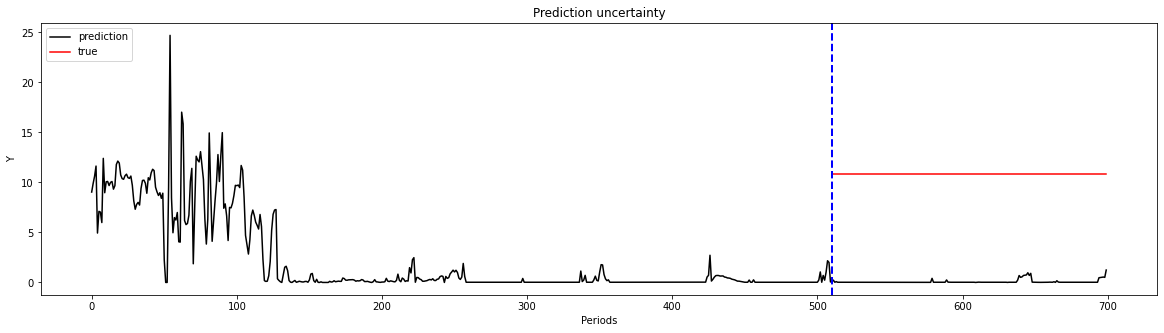

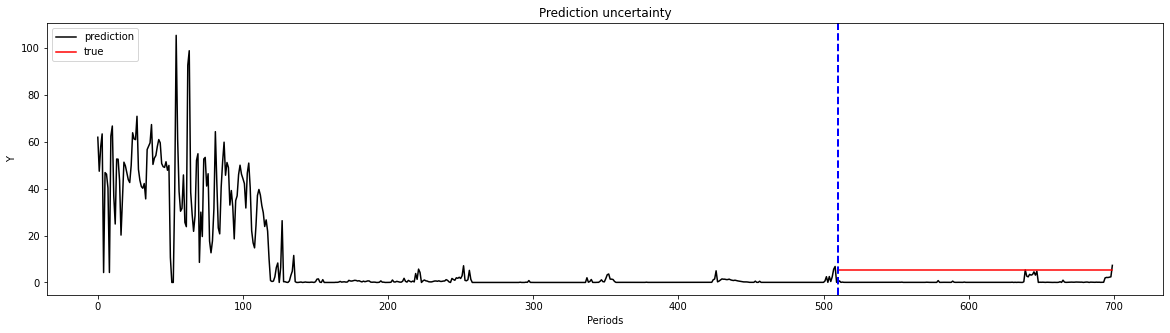

-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 90.11s | valid loss 0.03454 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  40 |    16/   84 batches | lr 0.002229 | 1083.12 ms | loss 0.10841 | ppl     1.11
| epoch  40 |    32/   84 batches | lr 0.002229 | 1110.12 ms | loss 0.02803 | ppl     1.03
| epoch  40 |    48/   84 batches | lr 0.002229 | 966.85 ms | loss 0.00906 | ppl     1.01
| epoch  40 |    64/   84 batches | lr 0.002229 | 1062.48 ms | loss 0.00597 | ppl     1.01
| epoch  40 |    80/   84 batches | lr 0.002229 | 1010.28 ms | loss 0.00059 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


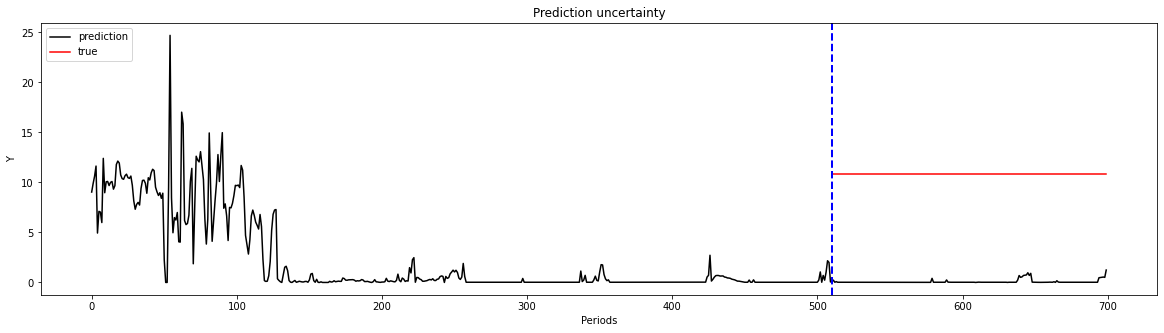

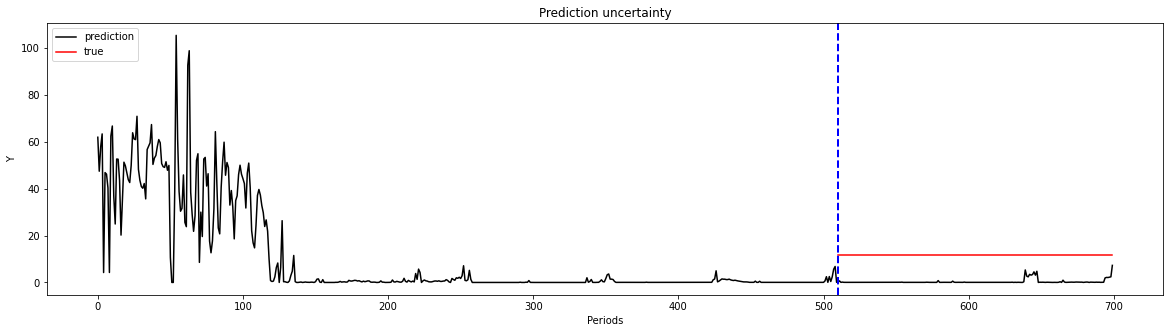

-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 100.59s | valid loss 0.03450 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  41 |    16/   84 batches | lr 0.002184 | 964.85 ms | loss 0.10860 | ppl     1.11
| epoch  41 |    32/   84 batches | lr 0.002184 | 906.67 ms | loss 0.02767 | ppl     1.03
| epoch  41 |    48/   84 batches | lr 0.002184 | 903.90 ms | loss 0.00897 | ppl     1.01
| epoch  41 |    64/   84 batches | lr 0.002184 | 904.34 ms | loss 0.00601 | ppl     1.01
| epoch  41 |    80/   84 batches | lr 0.002184 | 903.29 ms | loss 0.00059 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


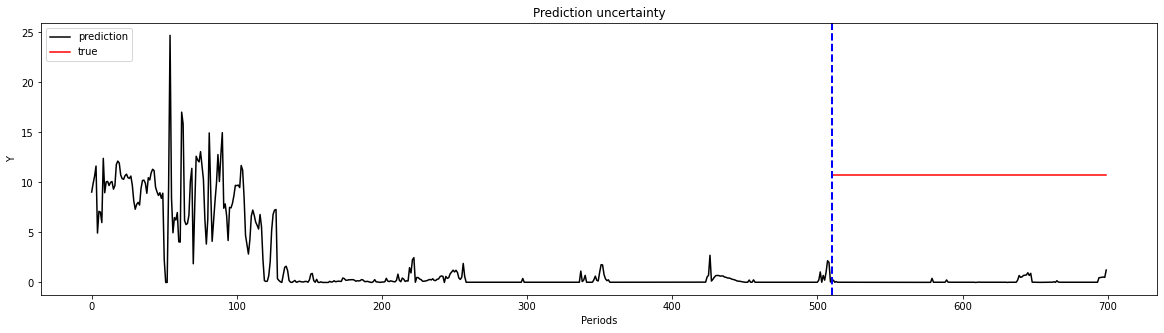

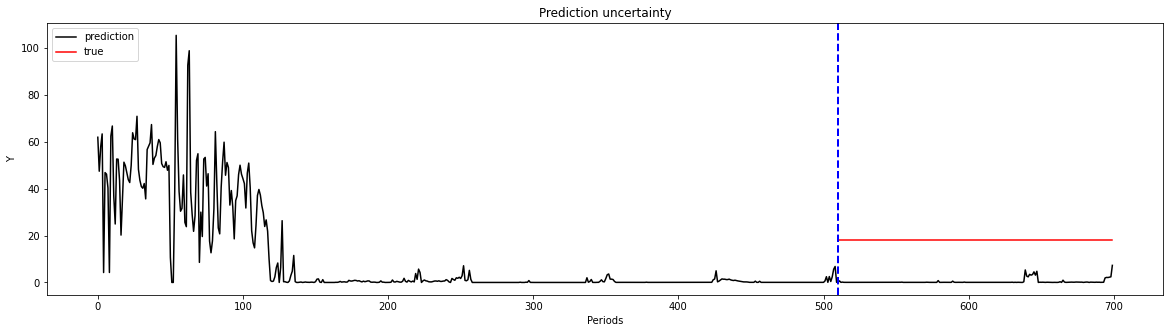

-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 89.18s | valid loss 0.03446 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  42 |    16/   84 batches | lr 0.002140 | 963.68 ms | loss 0.10878 | ppl     1.11
| epoch  42 |    32/   84 batches | lr 0.002140 | 905.90 ms | loss 0.02733 | ppl     1.03
| epoch  42 |    48/   84 batches | lr 0.002140 | 900.84 ms | loss 0.00889 | ppl     1.01
| epoch  42 |    64/   84 batches | lr 0.002140 | 908.37 ms | loss 0.00604 | ppl     1.01
| epoch  42 |    80/   84 batches | lr 0.002140 | 903.18 ms | loss 0.00060 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


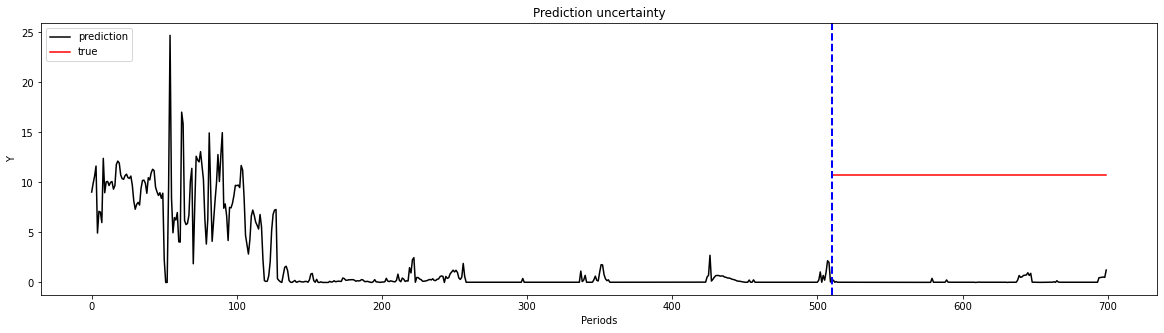

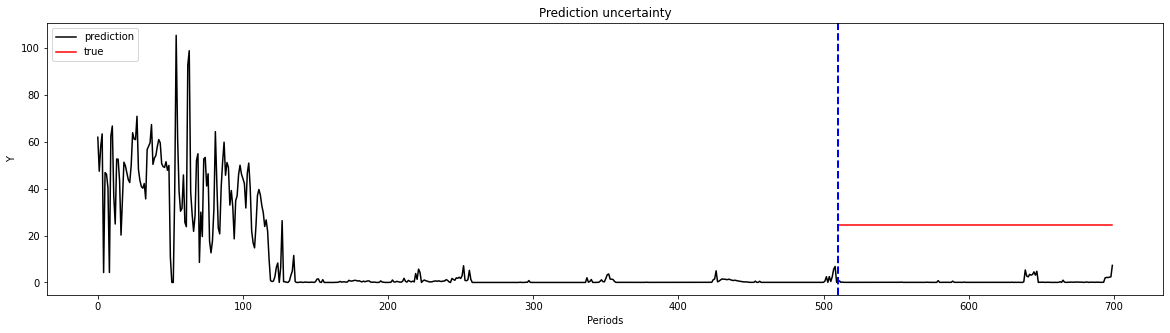

-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 89.28s | valid loss 0.03441 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  43 |    16/   84 batches | lr 0.002097 | 1007.31 ms | loss 0.10894 | ppl     1.12
| epoch  43 |    32/   84 batches | lr 0.002097 | 990.73 ms | loss 0.02700 | ppl     1.03
| epoch  43 |    48/   84 batches | lr 0.002097 | 978.49 ms | loss 0.00880 | ppl     1.01
| epoch  43 |    64/   84 batches | lr 0.002097 | 1031.33 ms | loss 0.00608 | ppl     1.01
| epoch  43 |    80/   84 batches | lr 0.002097 | 975.56 ms | loss 0.00061 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


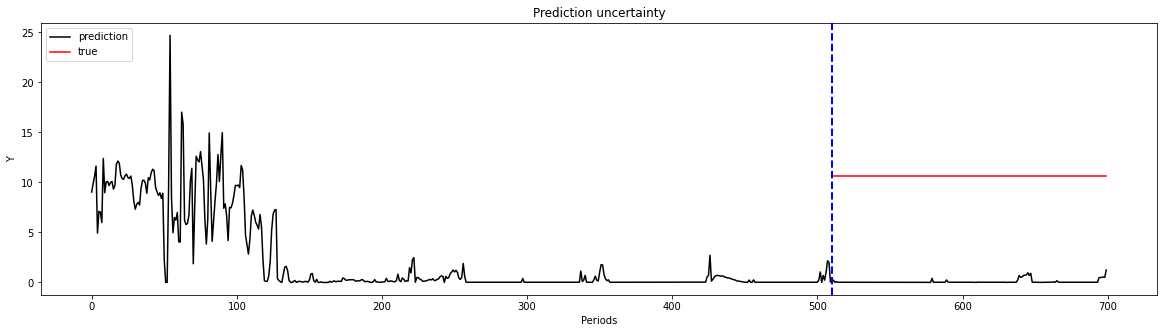

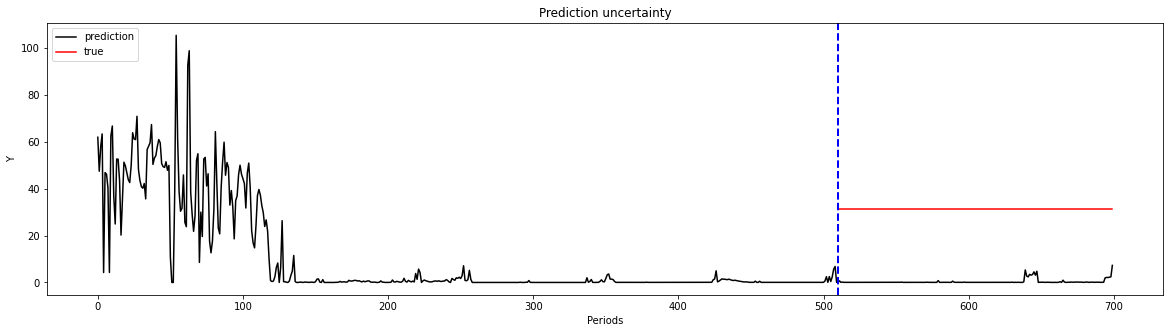

-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 95.41s | valid loss 0.03437 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  44 |    16/   84 batches | lr 0.002055 | 1015.51 ms | loss 0.10908 | ppl     1.12
| epoch  44 |    32/   84 batches | lr 0.002055 | 912.32 ms | loss 0.02668 | ppl     1.03
| epoch  44 |    48/   84 batches | lr 0.002055 | 908.65 ms | loss 0.00871 | ppl     1.01
| epoch  44 |    64/   84 batches | lr 0.002055 | 903.85 ms | loss 0.00611 | ppl     1.01
| epoch  44 |    80/   84 batches | lr 0.002055 | 911.71 ms | loss 0.00062 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


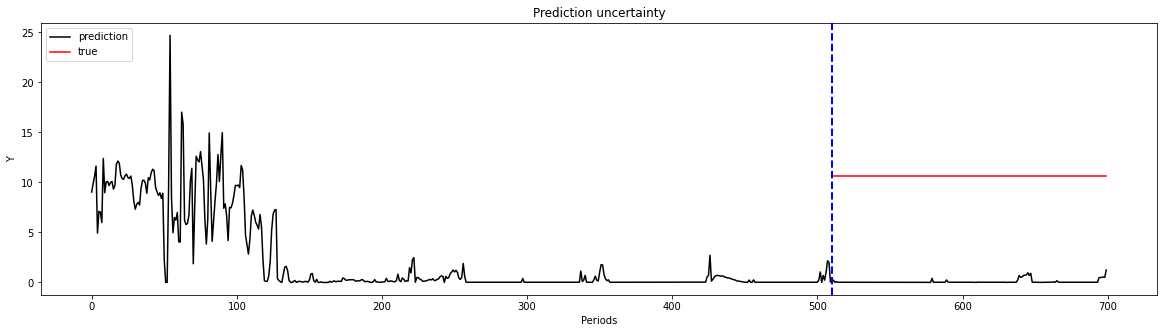

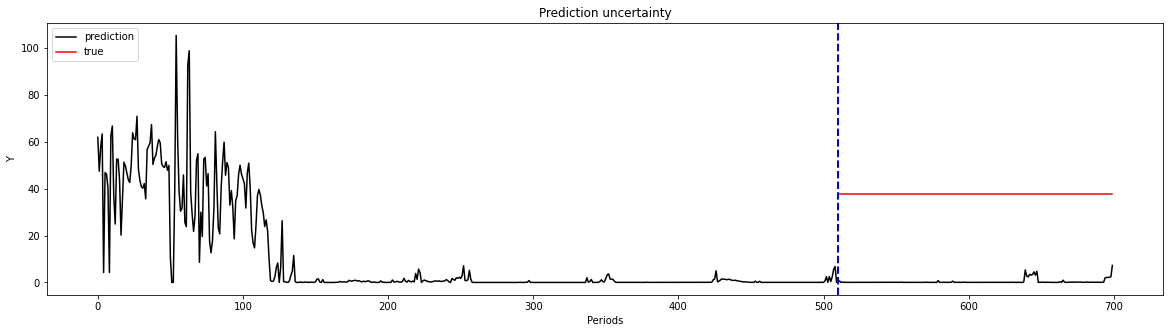

-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 88.70s | valid loss 0.03433 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  45 |    16/   84 batches | lr 0.002014 | 1034.54 ms | loss 0.10922 | ppl     1.12
| epoch  45 |    32/   84 batches | lr 0.002014 | 911.45 ms | loss 0.02637 | ppl     1.03
| epoch  45 |    48/   84 batches | lr 0.002014 | 901.71 ms | loss 0.00862 | ppl     1.01
| epoch  45 |    64/   84 batches | lr 0.002014 | 901.21 ms | loss 0.00614 | ppl     1.01
| epoch  45 |    80/   84 batches | lr 0.002014 | 903.01 ms | loss 0.00063 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


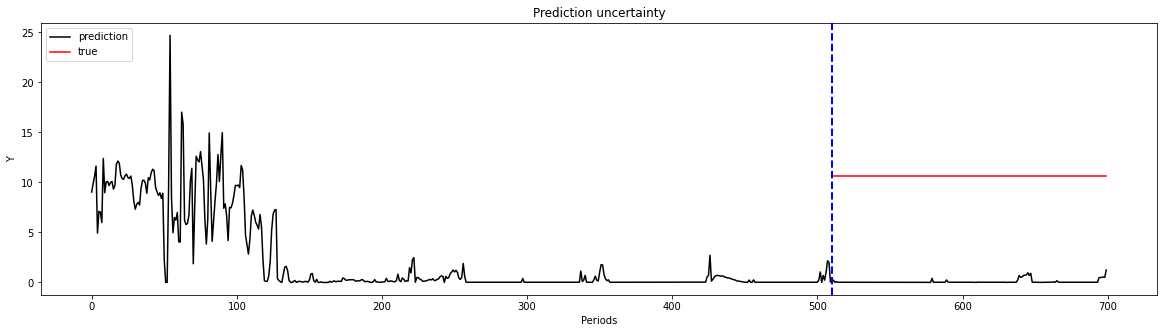

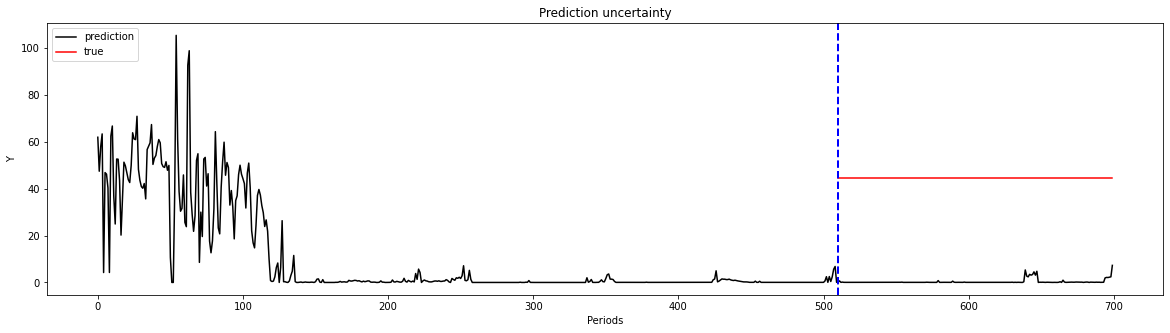

-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 88.50s | valid loss 0.03429 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  46 |    16/   84 batches | lr 0.001974 | 1017.87 ms | loss 0.10933 | ppl     1.12
| epoch  46 |    32/   84 batches | lr 0.001974 | 941.18 ms | loss 0.02607 | ppl     1.03
| epoch  46 |    48/   84 batches | lr 0.001974 | 896.61 ms | loss 0.00854 | ppl     1.01
| epoch  46 |    64/   84 batches | lr 0.001974 | 917.70 ms | loss 0.00617 | ppl     1.01
| epoch  46 |    80/   84 batches | lr 0.001974 | 908.95 ms | loss 0.00065 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


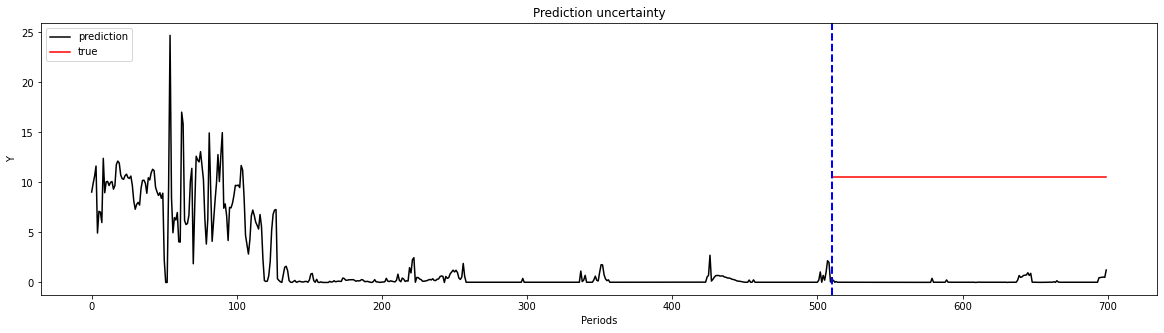

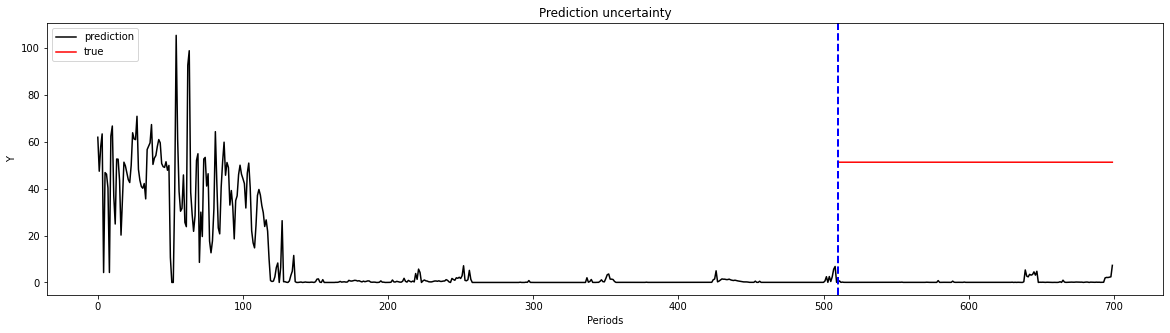

-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 90.51s | valid loss 0.03425 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  47 |    16/   84 batches | lr 0.001935 | 990.36 ms | loss 0.10944 | ppl     1.12
| epoch  47 |    32/   84 batches | lr 0.001935 | 962.77 ms | loss 0.02578 | ppl     1.03
| epoch  47 |    48/   84 batches | lr 0.001935 | 908.87 ms | loss 0.00845 | ppl     1.01
| epoch  47 |    64/   84 batches | lr 0.001935 | 919.70 ms | loss 0.00619 | ppl     1.01
| epoch  47 |    80/   84 batches | lr 0.001935 | 893.27 ms | loss 0.00067 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


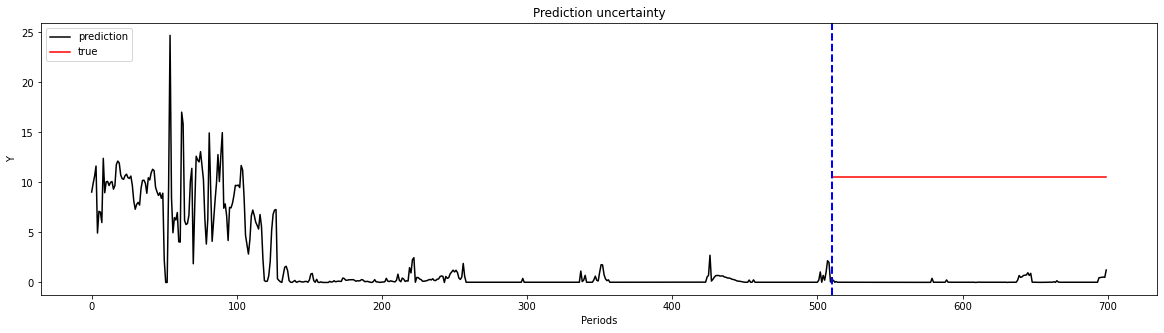

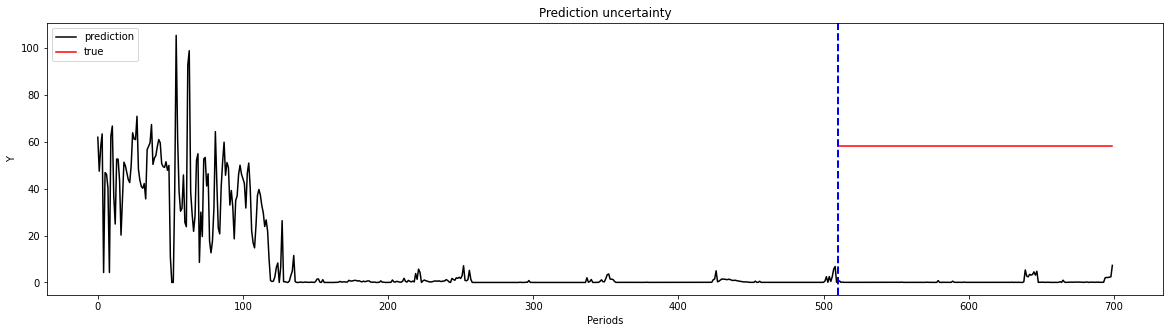

-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 89.40s | valid loss 0.03421 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  48 |    16/   84 batches | lr 0.001896 | 967.22 ms | loss 0.10954 | ppl     1.12
| epoch  48 |    32/   84 batches | lr 0.001896 | 965.50 ms | loss 0.02550 | ppl     1.03
| epoch  48 |    48/   84 batches | lr 0.001896 | 926.22 ms | loss 0.00837 | ppl     1.01
| epoch  48 |    64/   84 batches | lr 0.001896 | 914.80 ms | loss 0.00622 | ppl     1.01
| epoch  48 |    80/   84 batches | lr 0.001896 | 913.29 ms | loss 0.00069 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


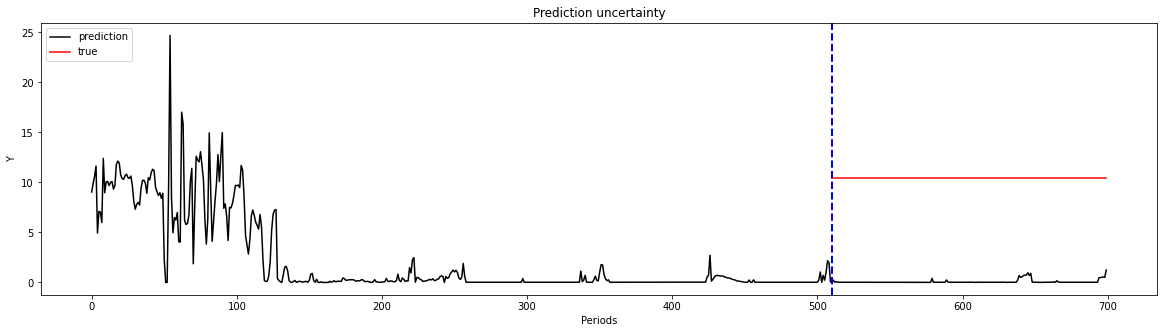

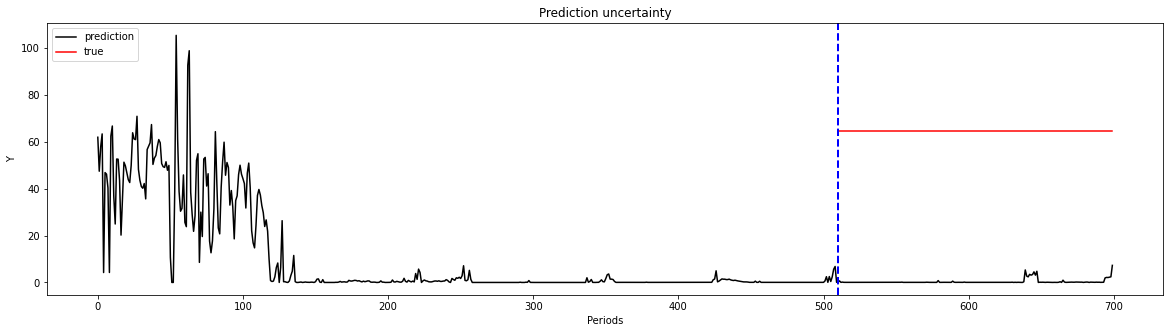

-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 89.49s | valid loss 0.03417 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  49 |    16/   84 batches | lr 0.001858 | 958.00 ms | loss 0.10963 | ppl     1.12
| epoch  49 |    32/   84 batches | lr 0.001858 | 887.87 ms | loss 0.02522 | ppl     1.03
| epoch  49 |    48/   84 batches | lr 0.001858 | 915.82 ms | loss 0.00828 | ppl     1.01
| epoch  49 |    64/   84 batches | lr 0.001858 | 916.65 ms | loss 0.00624 | ppl     1.01
| epoch  49 |    80/   84 batches | lr 0.001858 | 958.12 ms | loss 0.00071 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


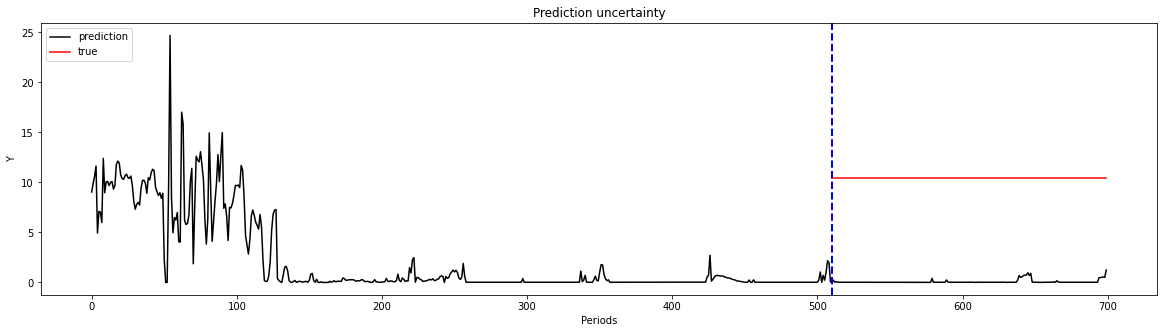

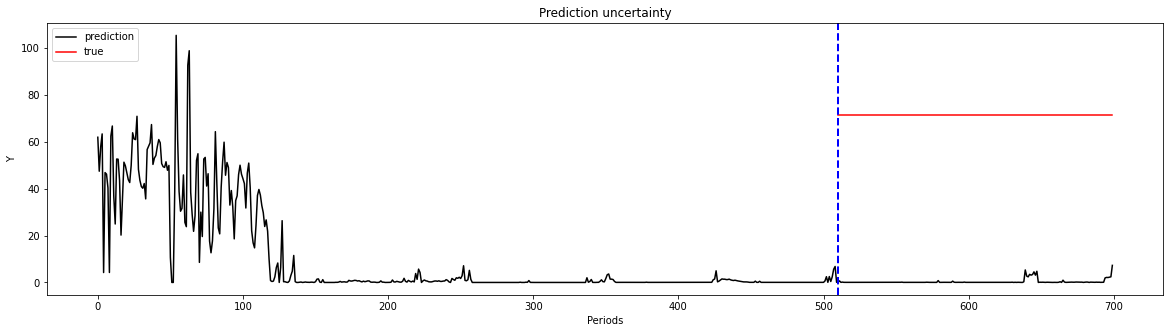

-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 90.06s | valid loss 0.03414 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  50 |    16/   84 batches | lr 0.001821 | 1092.15 ms | loss 0.10971 | ppl     1.12
| epoch  50 |    32/   84 batches | lr 0.001821 | 1005.66 ms | loss 0.02495 | ppl     1.03
| epoch  50 |    48/   84 batches | lr 0.001821 | 1106.69 ms | loss 0.00819 | ppl     1.01
| epoch  50 |    64/   84 batches | lr 0.001821 | 1118.30 ms | loss 0.00626 | ppl     1.01
| epoch  50 |    80/   84 batches | lr 0.001821 | 1005.20 ms | loss 0.00073 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


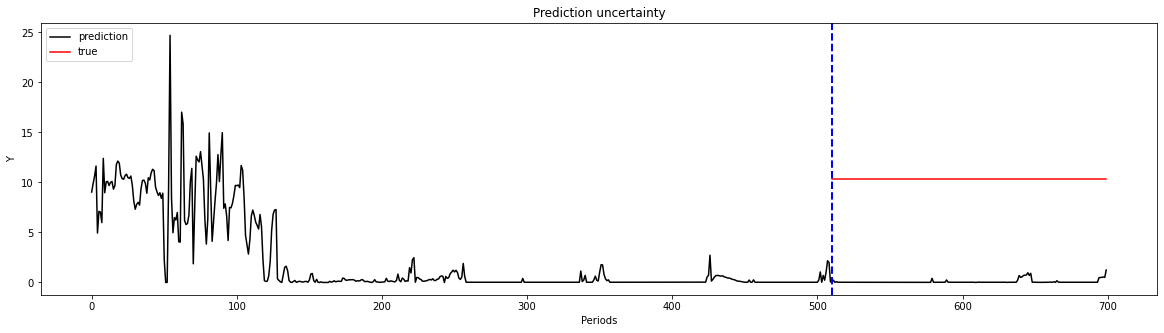

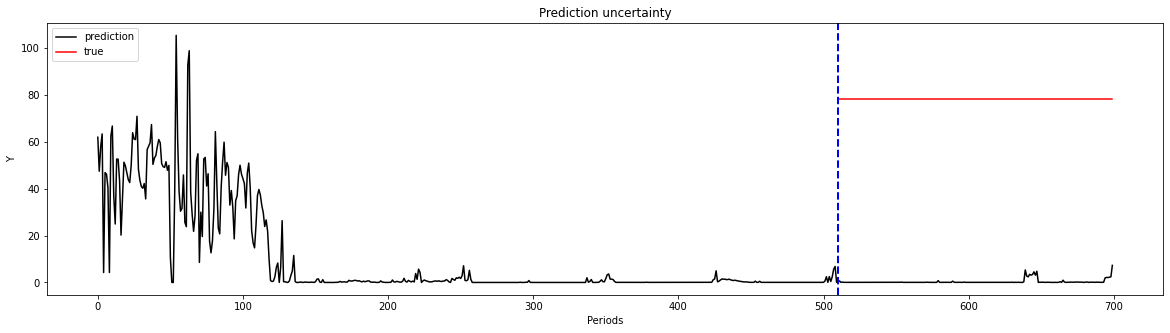

-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 103.68s | valid loss 0.03410 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  51 |    16/   84 batches | lr 0.001784 | 1365.80 ms | loss 0.10978 | ppl     1.12
| epoch  51 |    32/   84 batches | lr 0.001784 | 1328.15 ms | loss 0.02469 | ppl     1.02
| epoch  51 |    48/   84 batches | lr 0.001784 | 1482.02 ms | loss 0.00811 | ppl     1.01
| epoch  51 |    64/   84 batches | lr 0.001784 | 1343.41 ms | loss 0.00629 | ppl     1.01
| epoch  51 |    80/   84 batches | lr 0.001784 | 1436.05 ms | loss 0.00076 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


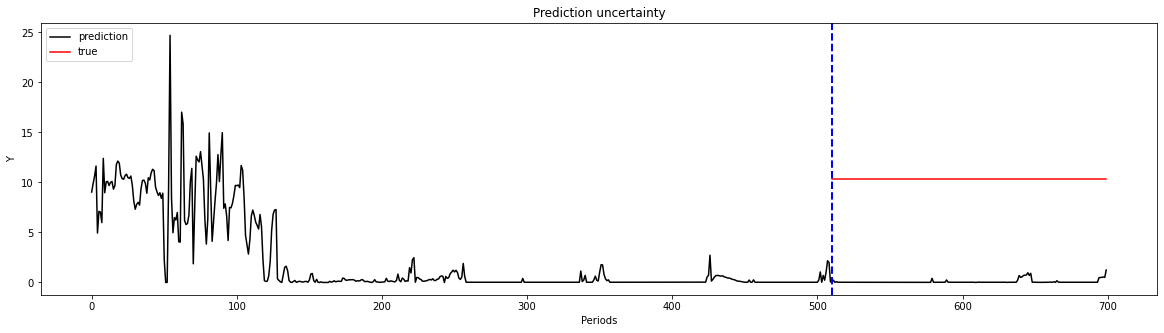

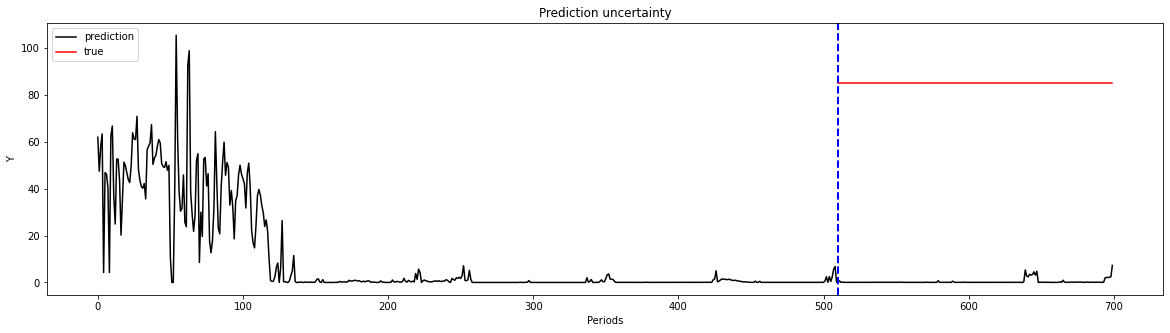

-----------------------------------------------------------------------------------------
| end of epoch  51 | time: 128.26s | valid loss 0.03407 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  52 |    16/   84 batches | lr 0.001749 | 962.40 ms | loss 0.10985 | ppl     1.12
| epoch  52 |    32/   84 batches | lr 0.001749 | 910.17 ms | loss 0.02444 | ppl     1.02
| epoch  52 |    48/   84 batches | lr 0.001749 | 1016.07 ms | loss 0.00802 | ppl     1.01
| epoch  52 |    64/   84 batches | lr 0.001749 | 987.34 ms | loss 0.00631 | ppl     1.01
| epoch  52 |    80/   84 batches | lr 0.001749 | 1007.24 ms | loss 0.00078 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


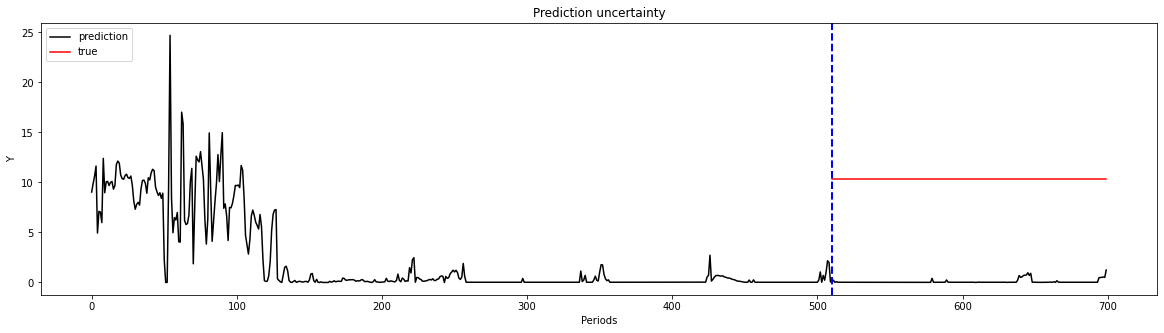

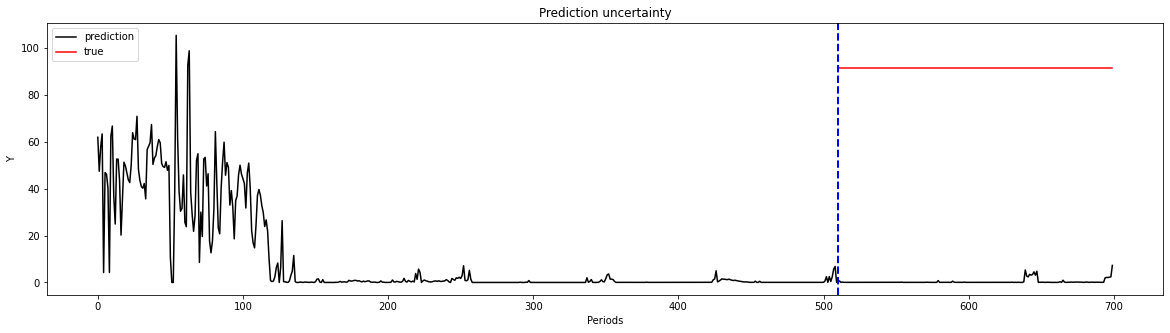

-----------------------------------------------------------------------------------------
| end of epoch  52 | time: 95.97s | valid loss 0.03403 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  53 |    16/   84 batches | lr 0.001714 | 1016.75 ms | loss 0.10990 | ppl     1.12
| epoch  53 |    32/   84 batches | lr 0.001714 | 977.36 ms | loss 0.02419 | ppl     1.02
| epoch  53 |    48/   84 batches | lr 0.001714 | 1038.07 ms | loss 0.00794 | ppl     1.01
| epoch  53 |    64/   84 batches | lr 0.001714 | 1009.60 ms | loss 0.00632 | ppl     1.01
| epoch  53 |    80/   84 batches | lr 0.001714 | 973.86 ms | loss 0.00081 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


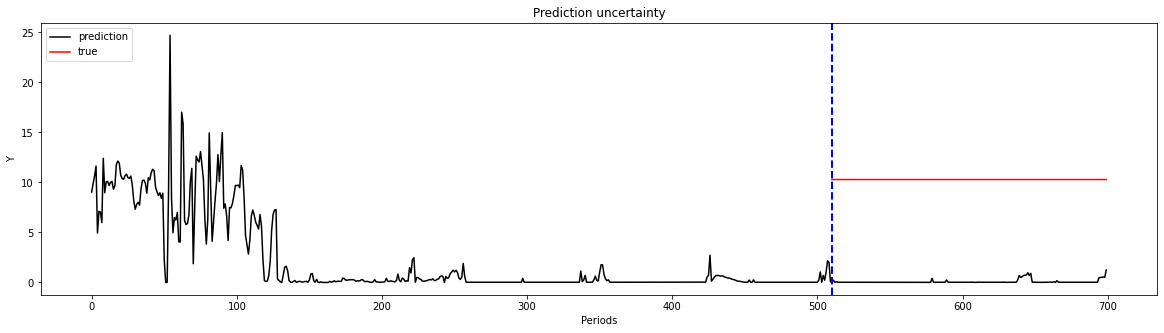

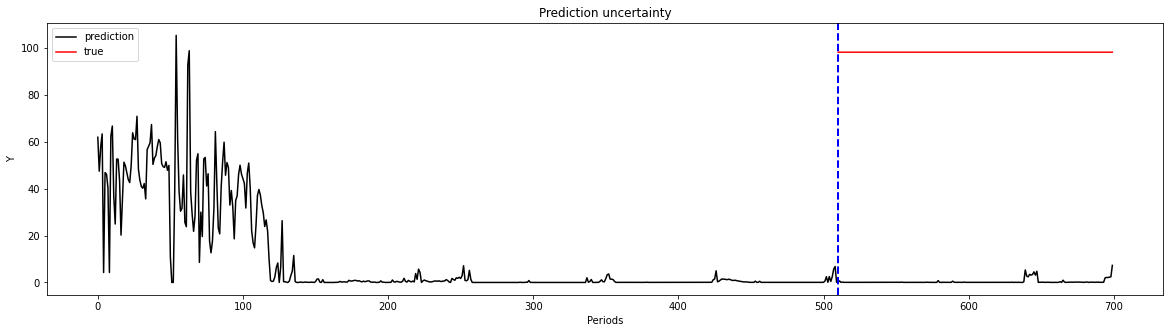

-----------------------------------------------------------------------------------------
| end of epoch  53 | time: 96.13s | valid loss 0.03400 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  54 |    16/   84 batches | lr 0.001679 | 1047.08 ms | loss 0.10994 | ppl     1.12
| epoch  54 |    32/   84 batches | lr 0.001679 | 934.13 ms | loss 0.02395 | ppl     1.02
| epoch  54 |    48/   84 batches | lr 0.001679 | 928.38 ms | loss 0.00786 | ppl     1.01
| epoch  54 |    64/   84 batches | lr 0.001679 | 928.55 ms | loss 0.00634 | ppl     1.01
| epoch  54 |    80/   84 batches | lr 0.001679 | 898.37 ms | loss 0.00083 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


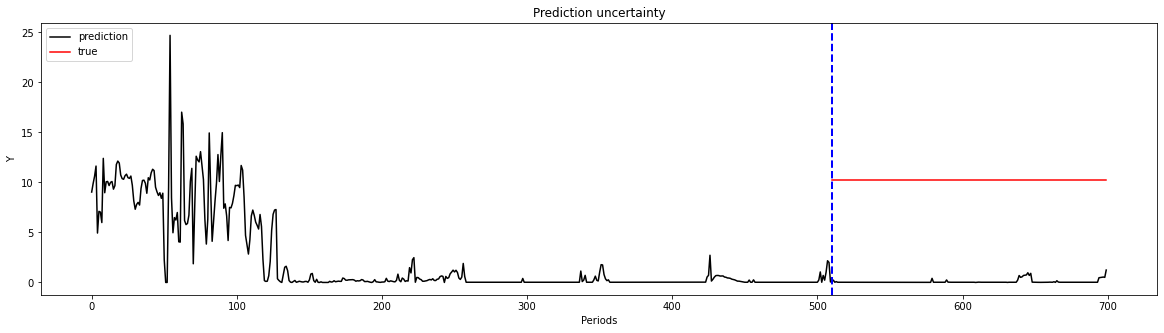

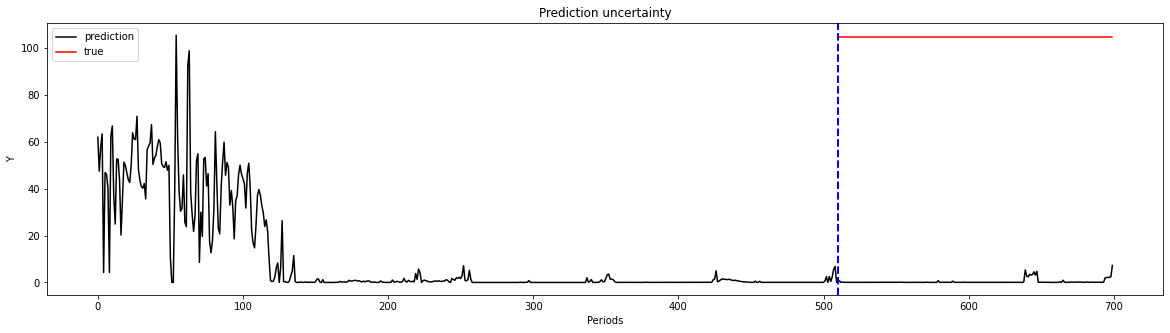

-----------------------------------------------------------------------------------------
| end of epoch  54 | time: 89.85s | valid loss 0.03397 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  55 |    16/   84 batches | lr 0.001646 | 960.00 ms | loss 0.10998 | ppl     1.12
| epoch  55 |    32/   84 batches | lr 0.001646 | 904.70 ms | loss 0.02372 | ppl     1.02
| epoch  55 |    48/   84 batches | lr 0.001646 | 962.30 ms | loss 0.00778 | ppl     1.01
| epoch  55 |    64/   84 batches | lr 0.001646 | 1033.14 ms | loss 0.00636 | ppl     1.01
| epoch  55 |    80/   84 batches | lr 0.001646 | 931.74 ms | loss 0.00086 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


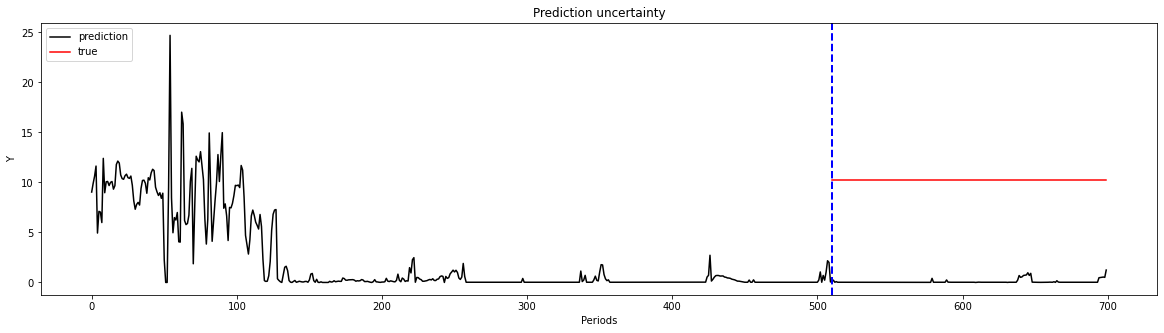

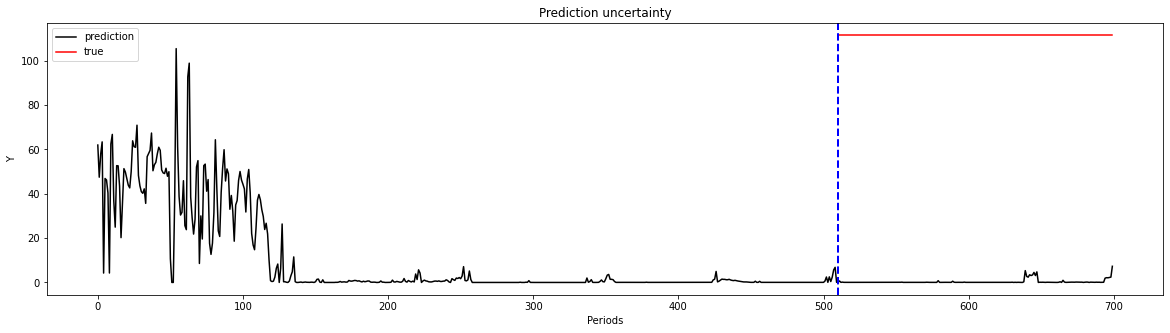

-----------------------------------------------------------------------------------------
| end of epoch  55 | time: 92.14s | valid loss 0.03394 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  56 |    16/   84 batches | lr 0.001613 | 960.17 ms | loss 0.11001 | ppl     1.12
| epoch  56 |    32/   84 batches | lr 0.001613 | 910.93 ms | loss 0.02349 | ppl     1.02
| epoch  56 |    48/   84 batches | lr 0.001613 | 898.28 ms | loss 0.00770 | ppl     1.01
| epoch  56 |    64/   84 batches | lr 0.001613 | 969.59 ms | loss 0.00638 | ppl     1.01
| epoch  56 |    80/   84 batches | lr 0.001613 | 922.53 ms | loss 0.00089 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


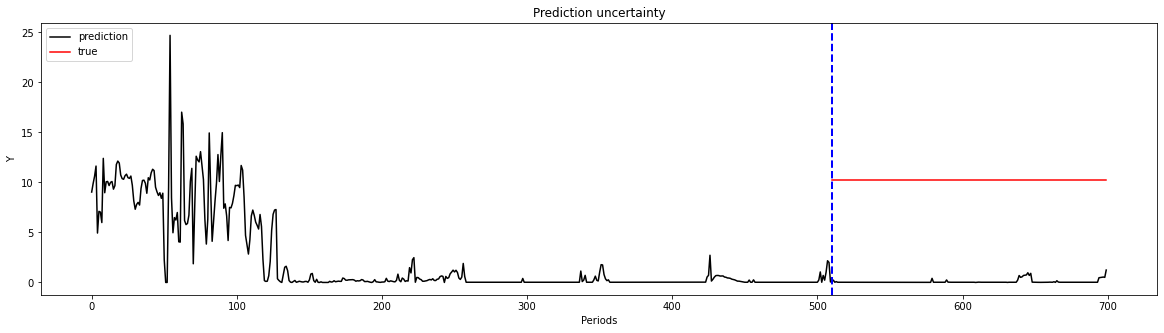

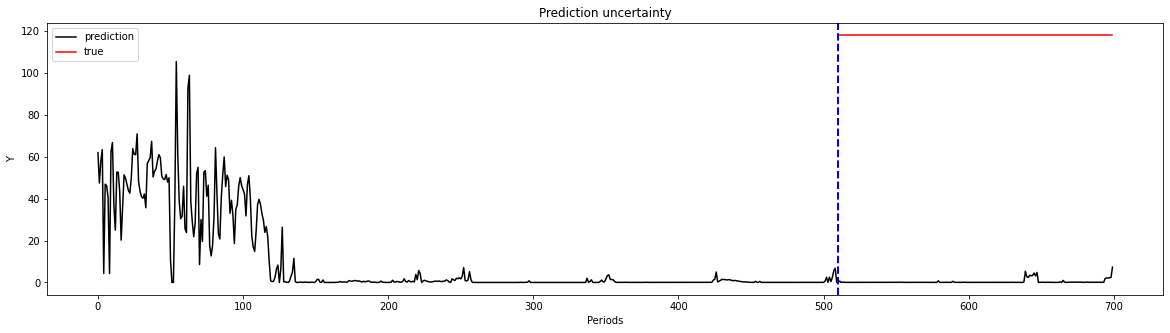

-----------------------------------------------------------------------------------------
| end of epoch  56 | time: 89.10s | valid loss 0.03391 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  57 |    16/   84 batches | lr 0.001581 | 954.89 ms | loss 0.11003 | ppl     1.12
| epoch  57 |    32/   84 batches | lr 0.001581 | 903.21 ms | loss 0.02327 | ppl     1.02
| epoch  57 |    48/   84 batches | lr 0.001581 | 894.13 ms | loss 0.00762 | ppl     1.01
| epoch  57 |    64/   84 batches | lr 0.001581 | 1002.36 ms | loss 0.00639 | ppl     1.01
| epoch  57 |    80/   84 batches | lr 0.001581 | 1056.00 ms | loss 0.00092 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


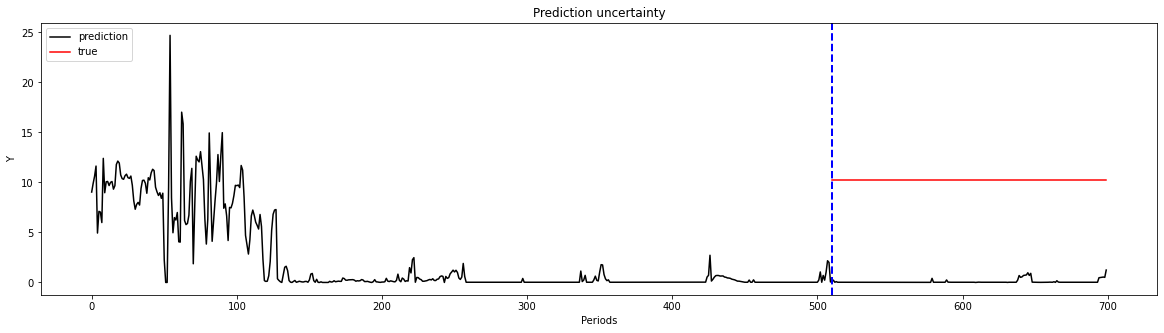

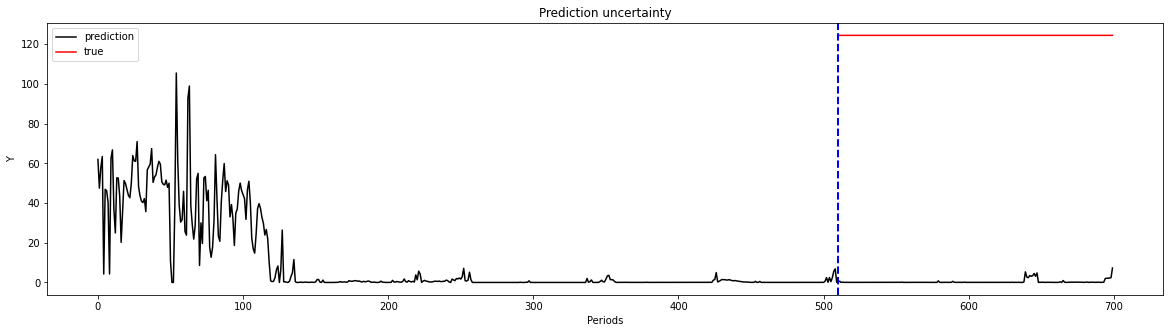

-----------------------------------------------------------------------------------------
| end of epoch  57 | time: 94.53s | valid loss 0.03389 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  58 |    16/   84 batches | lr 0.001549 | 1018.79 ms | loss 0.11004 | ppl     1.12
| epoch  58 |    32/   84 batches | lr 0.001549 | 948.60 ms | loss 0.02306 | ppl     1.02
| epoch  58 |    48/   84 batches | lr 0.001549 | 932.06 ms | loss 0.00754 | ppl     1.01
| epoch  58 |    64/   84 batches | lr 0.001549 | 967.98 ms | loss 0.00641 | ppl     1.01
| epoch  58 |    80/   84 batches | lr 0.001549 | 1013.04 ms | loss 0.00095 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


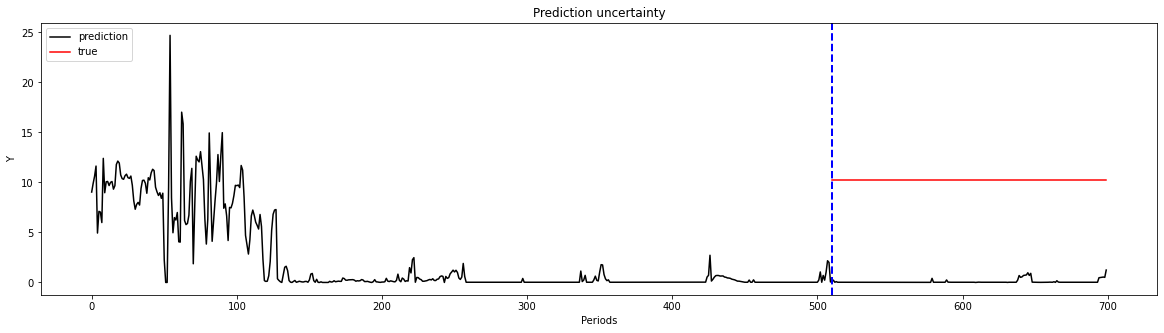

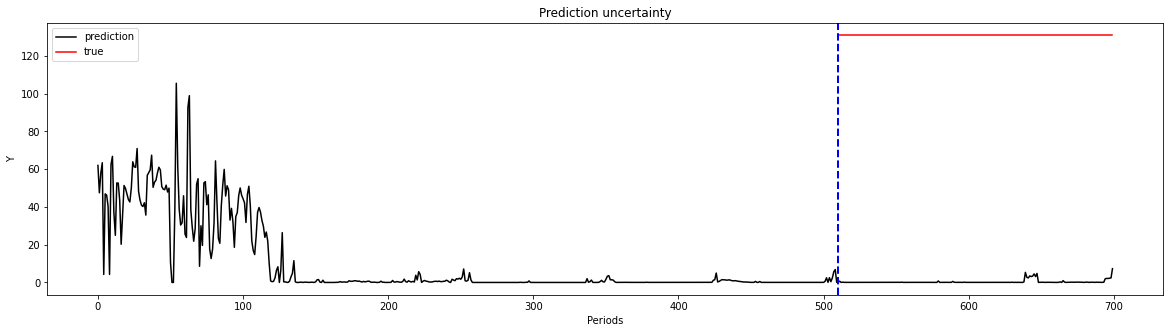

-----------------------------------------------------------------------------------------
| end of epoch  58 | time: 94.37s | valid loss 0.03386 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  59 |    16/   84 batches | lr 0.001518 | 1091.54 ms | loss 0.11005 | ppl     1.12
| epoch  59 |    32/   84 batches | lr 0.001518 | 1007.21 ms | loss 0.02286 | ppl     1.02
| epoch  59 |    48/   84 batches | lr 0.001518 | 943.59 ms | loss 0.00746 | ppl     1.01
| epoch  59 |    64/   84 batches | lr 0.001518 | 986.67 ms | loss 0.00642 | ppl     1.01
| epoch  59 |    80/   84 batches | lr 0.001518 | 982.90 ms | loss 0.00098 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


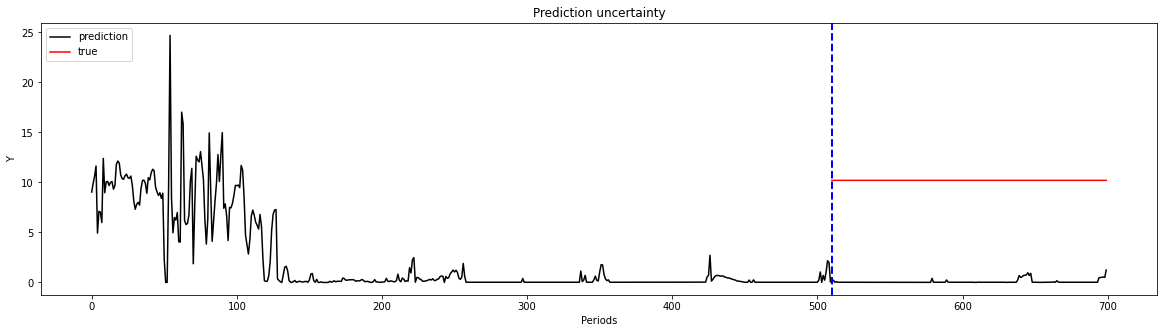

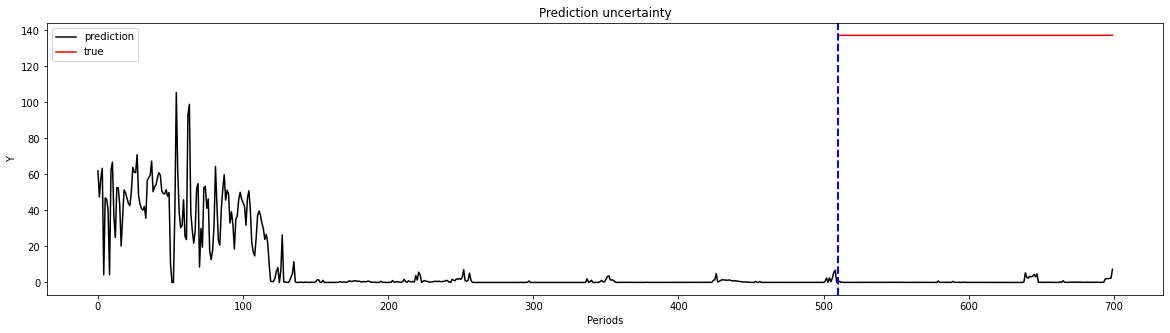

-----------------------------------------------------------------------------------------
| end of epoch  59 | time: 97.49s | valid loss 0.03383 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  60 |    16/   84 batches | lr 0.001488 | 1058.00 ms | loss 0.11005 | ppl     1.12
| epoch  60 |    32/   84 batches | lr 0.001488 | 1022.87 ms | loss 0.02266 | ppl     1.02
| epoch  60 |    48/   84 batches | lr 0.001488 | 991.57 ms | loss 0.00738 | ppl     1.01
| epoch  60 |    64/   84 batches | lr 0.001488 | 977.48 ms | loss 0.00643 | ppl     1.01
| epoch  60 |    80/   84 batches | lr 0.001488 | 931.28 ms | loss 0.00102 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


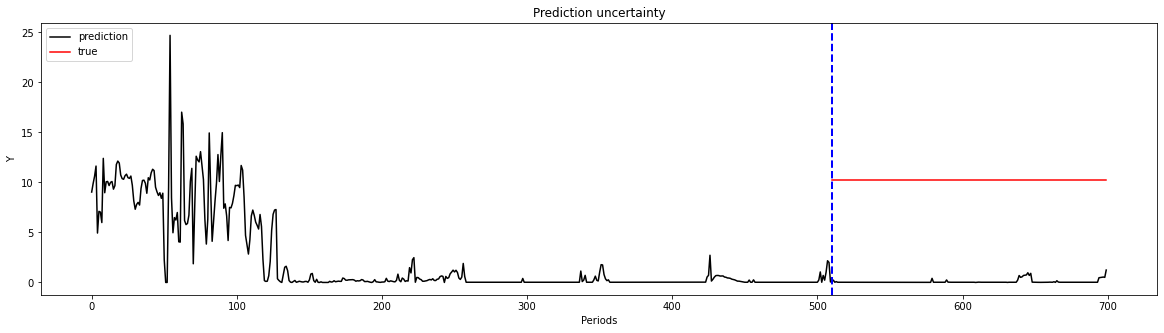

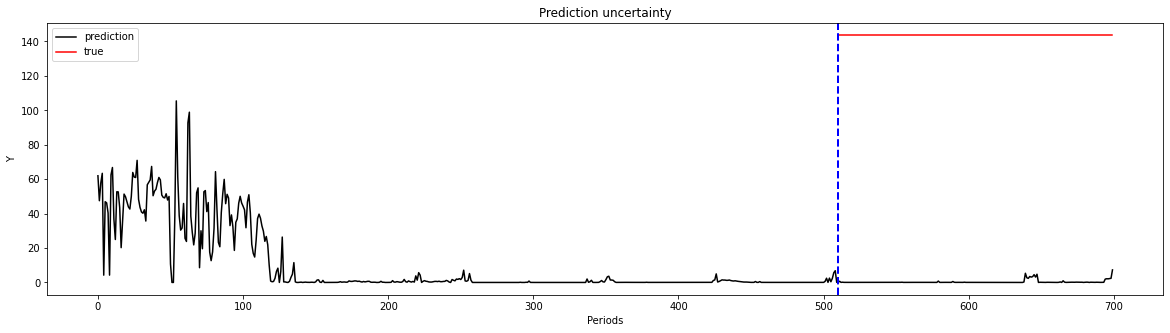

-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 100.34s | valid loss 0.03381 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  61 |    16/   84 batches | lr 0.001458 | 1058.19 ms | loss 0.11005 | ppl     1.12
| epoch  61 |    32/   84 batches | lr 0.001458 | 1280.68 ms | loss 0.02246 | ppl     1.02
| epoch  61 |    48/   84 batches | lr 0.001458 | 1200.86 ms | loss 0.00731 | ppl     1.01
| epoch  61 |    64/   84 batches | lr 0.001458 | 1195.58 ms | loss 0.00645 | ppl     1.01
| epoch  61 |    80/   84 batches | lr 0.001458 | 1121.92 ms | loss 0.00105 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


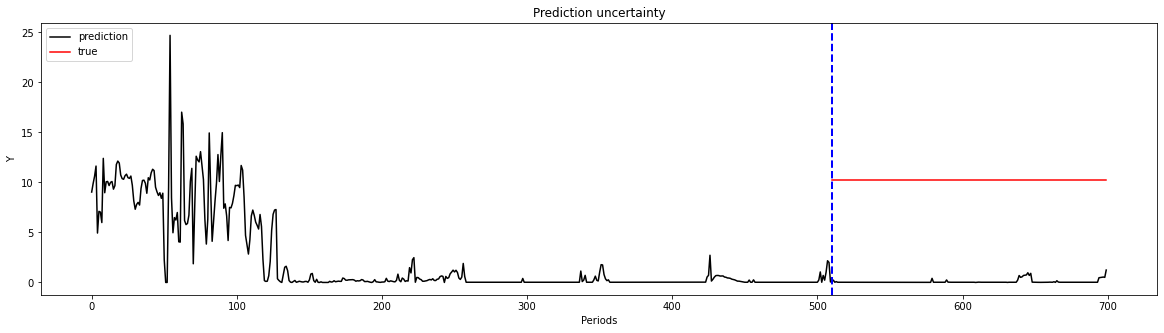

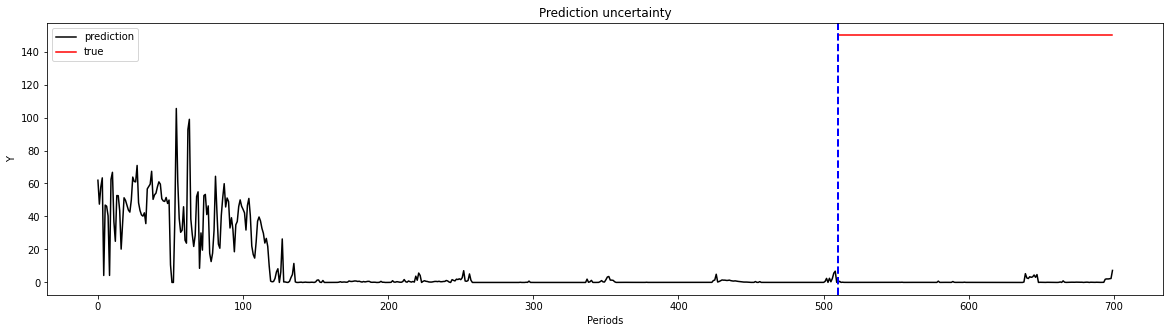

-----------------------------------------------------------------------------------------
| end of epoch  61 | time: 119.83s | valid loss 0.03379 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  62 |    16/   84 batches | lr 0.001429 | 1079.75 ms | loss 0.11003 | ppl     1.12
| epoch  62 |    32/   84 batches | lr 0.001429 | 987.50 ms | loss 0.02228 | ppl     1.02
| epoch  62 |    48/   84 batches | lr 0.001429 | 946.71 ms | loss 0.00723 | ppl     1.01


In [ ]:
train_data, val_data,scaler = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 1 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 